In [2]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.ipc_collect()
#device = "cpu"

In [3]:
 def plot_stuff(model,X,y,x_biased,mbins=100,histbins=None,name='Naive DNN'):
    if histbins == None:
        histbins=mbins
    predictions = np.array(model(X).tolist()).flatten()
    metrics_test = Metrics(validation=True)
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    x_biased = (x_biased+1)*0.5 *250 
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=histbins,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m = x_biased[y==1]
    sorted_m = np.argsort(m)
    scores = predictions[y==1][sorted_m].reshape(mbins,-1)
    m = m[sorted_m]
    m = m.reshape(mbins,-1).mean(axis=1)
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    plt.show()
    return (1/JSD,R50)

In [4]:
# mbins = 10
# mcontent = 4
# li = LegendreIntegral.apply
# fitter = LegendreFitter(mbins=mbins,power=2)
# inputTensor = torch.DoubleTensor(np.random.rand(mbins,mcontent)).sort(axis=1)[0]
# inputTensor.requires_grad_(True)
# sbins = 1000
# integral = li(inputTensor,fitter,sbins
#              )
# integral
# gradcheck(li,(inputTensor,fitter,sbins
#              ),eps=0.01,atol=0.01)

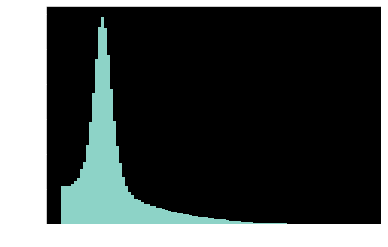

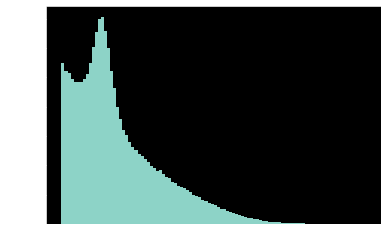

device: cuda:0


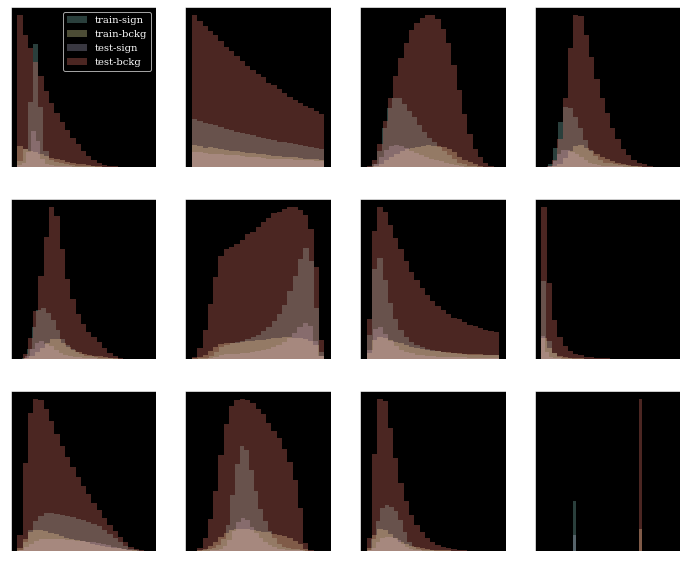

In [5]:
#dataset 
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
train[::,0] = 2*train[::,0]-1
#train[::,0][train_labels==1] = 2*(np.argsort(train[::,0][train_labels==1]))/(train_labels==1).sum()-1

plt.hist(train[::,0],bins=100)
plt.show()

maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)
val[::,0] = 2*val[::,0]-1
plt.hist(val[::,0],bins=100)
plt.show()

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
test = files["test"]
test_labels=test[::,-1]
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)
test[::,0] = 2*test[::,0]-1
X = torch.from_numpy(test[:,1:11]).float().to(device)

print('device:', device)



# maxdata = val.max(axis=0)
# mindata = val.min(axis=0)
# val = (val-mindata)/(maxdata-mindata)

# m,dm = np.histogram(train[::,0],bins=train.shape[0],density=True)
# train[::,0] = np.cumsum(m*(dm[1]-dm[0]))
# m,dm = np.histogram(val[::,0],bins=val.shape[0],density=True)
# val[::,0] = np.cumsum(m*(dm[1]-dm[0]))
# m = train[::,0].argsort()
# m = m/m.size
#train[::,0] = 2*train[::,0]-1
# m = val[::,0].argsort()
# m = m/m.size
# val[::,0] = 2*m-1
fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=25,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=25,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
    

In [6]:
params = {'epochs'     : 200,
          'interval'   : 200,
          'batch_size' : 2048,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

# Flat bins 

Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (378.8s)
 Train: loss:0.2925, acc:75% || Val: loss: 0.0763, acc:87%, R50: 25.6032, 1/JSD: 1.5335


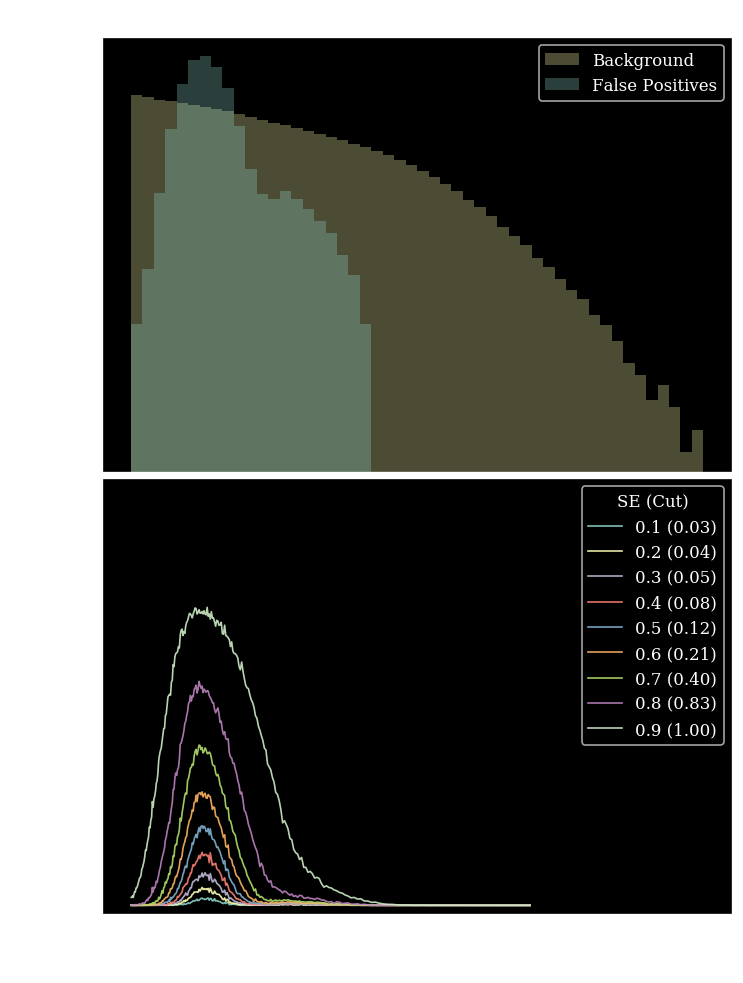

Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (383.5s)
 Train: loss:0.2902, acc:74% || Val: loss: 0.0808, acc:87%, R50: 22.5873, 1/JSD: 2.1330


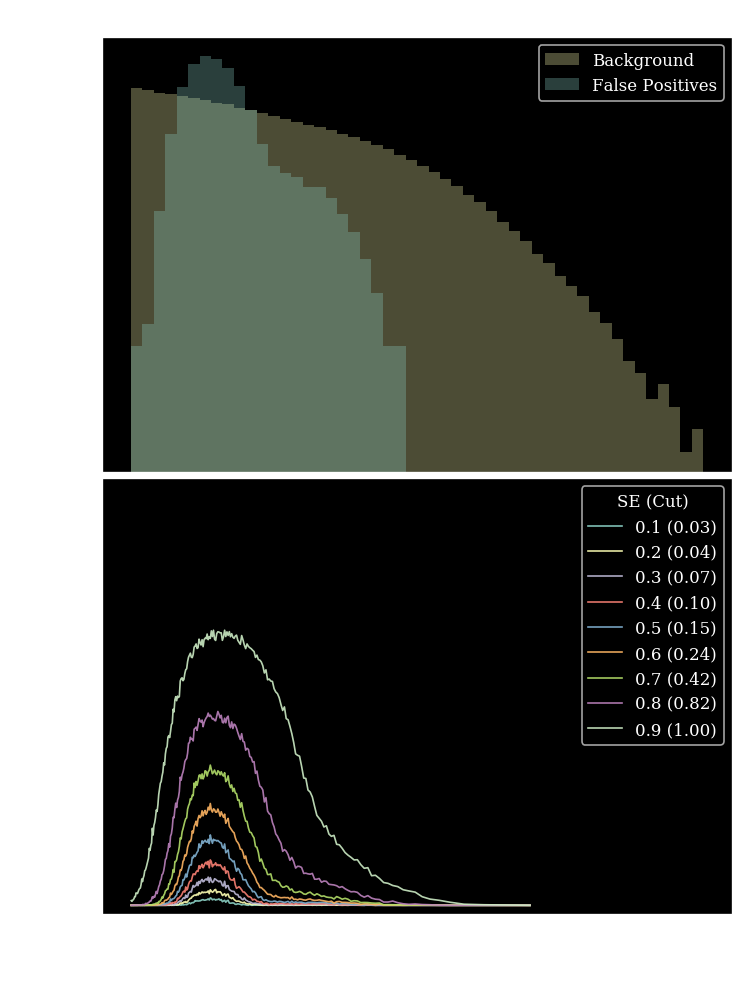

Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (408.1s)
 Train: loss:0.3843, acc:66% || Val: loss: 0.1095, acc:83%, R50: 10.1905, 1/JSD: 15.3196


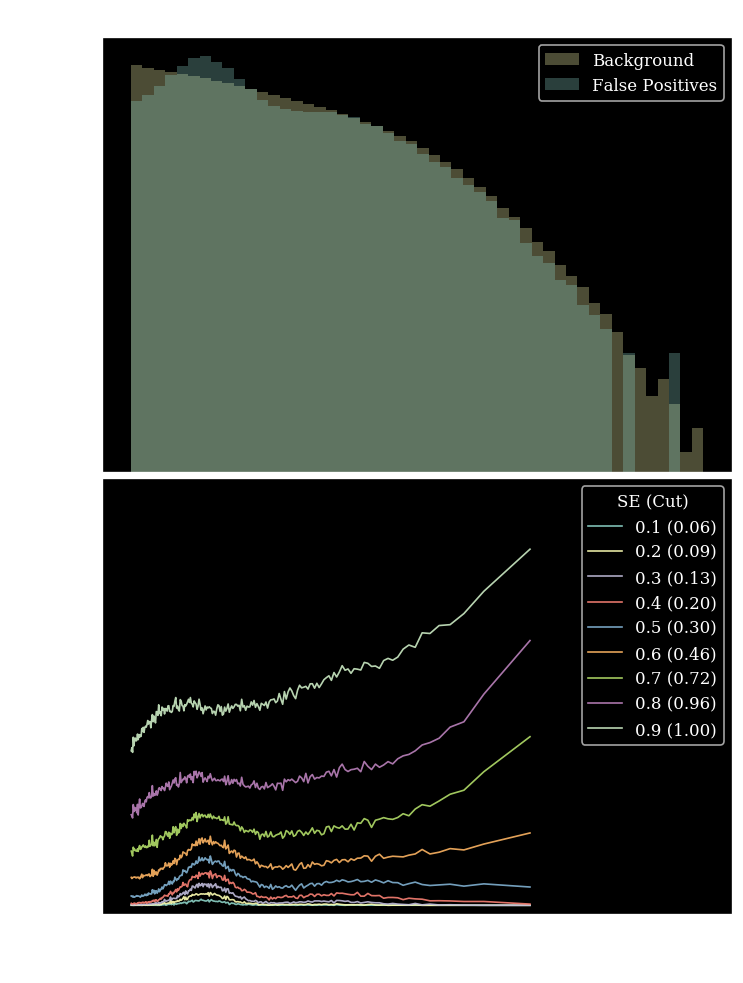

Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (388.5s)
 Train: loss:0.4121, acc:65% || Val: loss: 0.1153, acc:84%, R50: 10.4239, 1/JSD: 15.4955


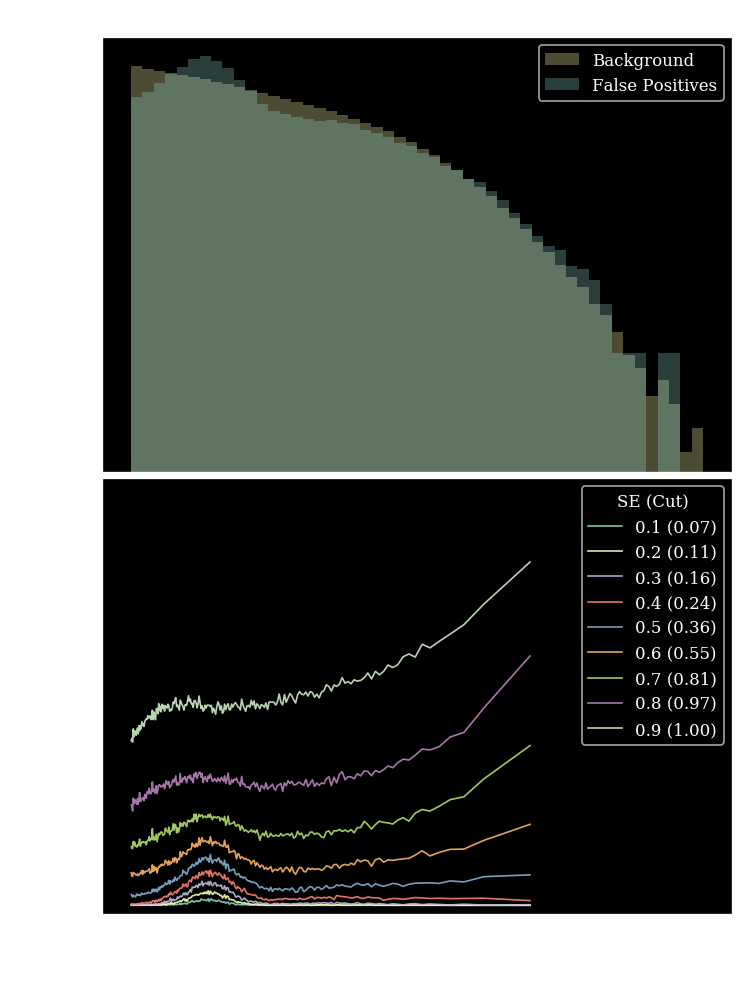

Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (384.7s)
 Train: loss:0.5117, acc:52% || Val: loss: 0.1559, acc:83%, R50: 16.9552, 1/JSD: 4.2357


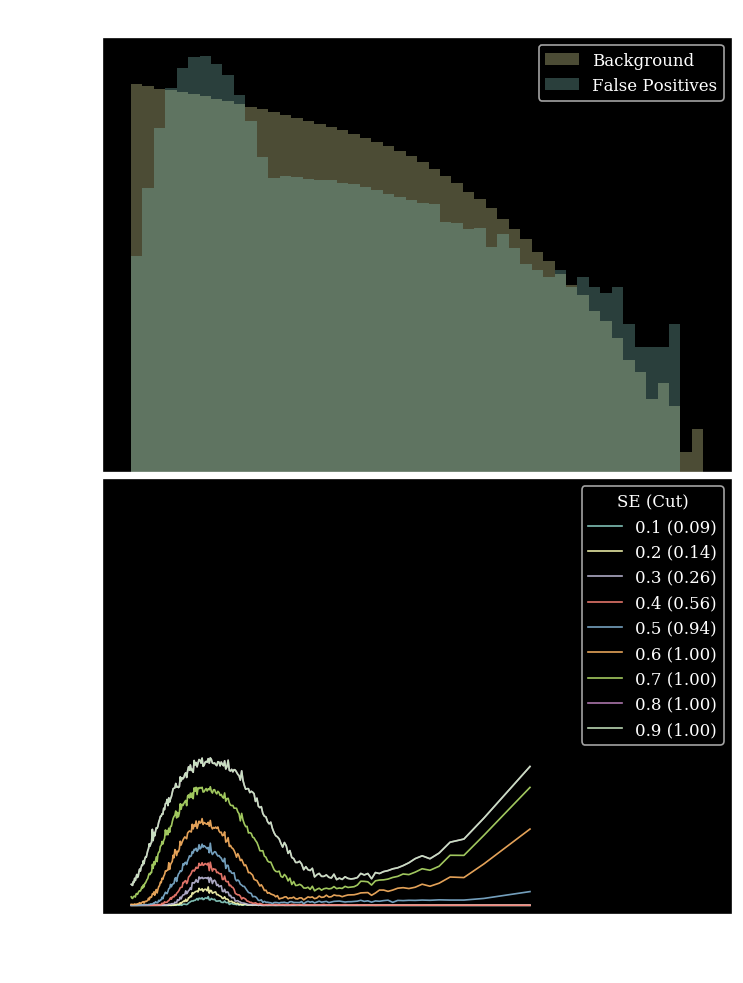

Entering Training...


KeyboardInterrupt: 

In [6]:
jsdR50flat = []
for i,bins in enumerate([1,2,5,10,50,60,75,85,100,110,120]):
    frac=50
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)
    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=1,bins=bins,memory=False)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN bins:{bins}",X=X,
                   y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
    jsdR50flat.append(out)

In [ ]:
asfdsdf 

# Flat str

strength 1
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (405.8s)
 Train: loss:0.2019, acc:79% || Val: loss: 0.0586, acc:86%, R50: 24.9188, 1/JSD: 1.5332


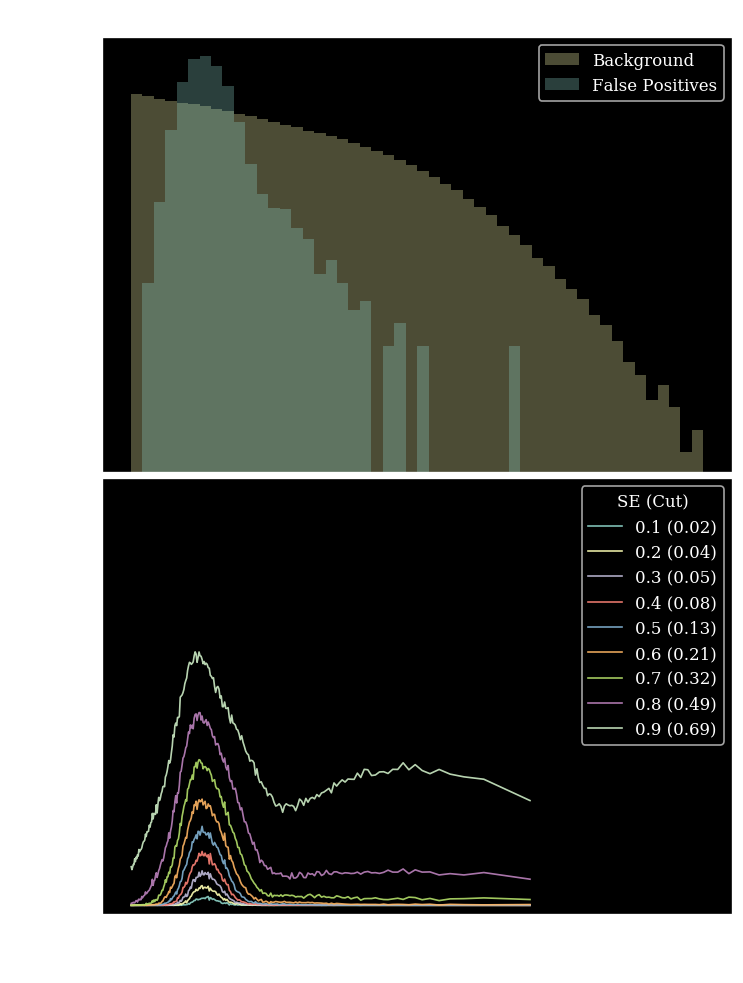

strength 1
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (391.6s)
 Train: loss:0.2058, acc:79% || Val: loss: 0.0590, acc:86%, R50: 24.8588, 1/JSD: 1.6208


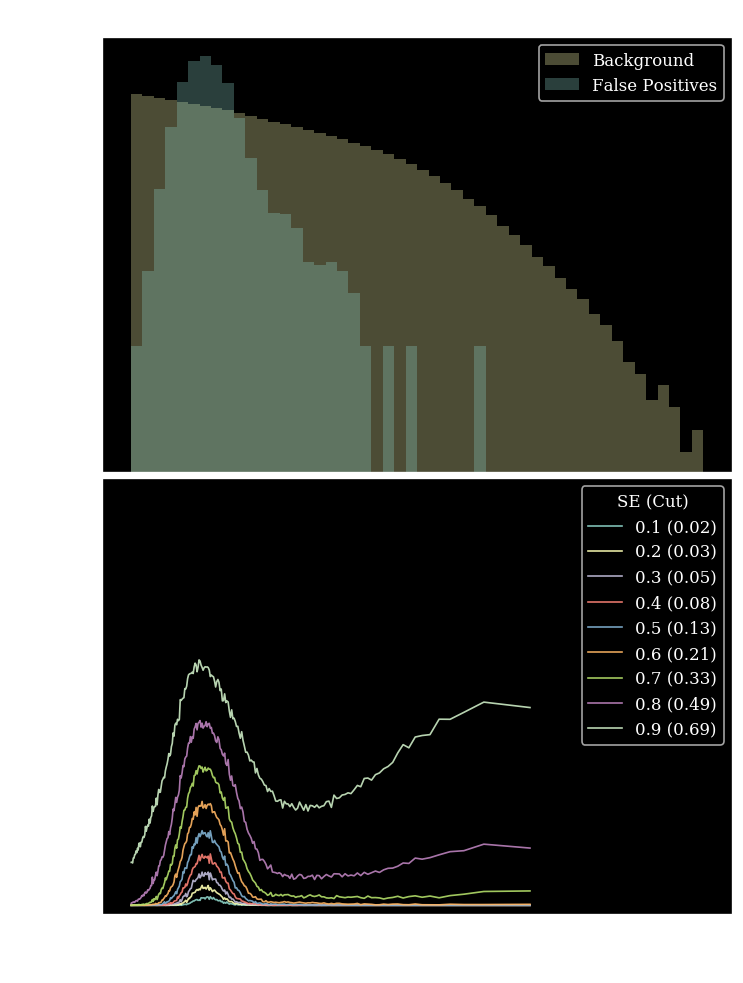

strength 1
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (396.8s)
 Train: loss:0.2098, acc:79% || Val: loss: 0.0594, acc:86%, R50: 24.7655, 1/JSD: 1.5971


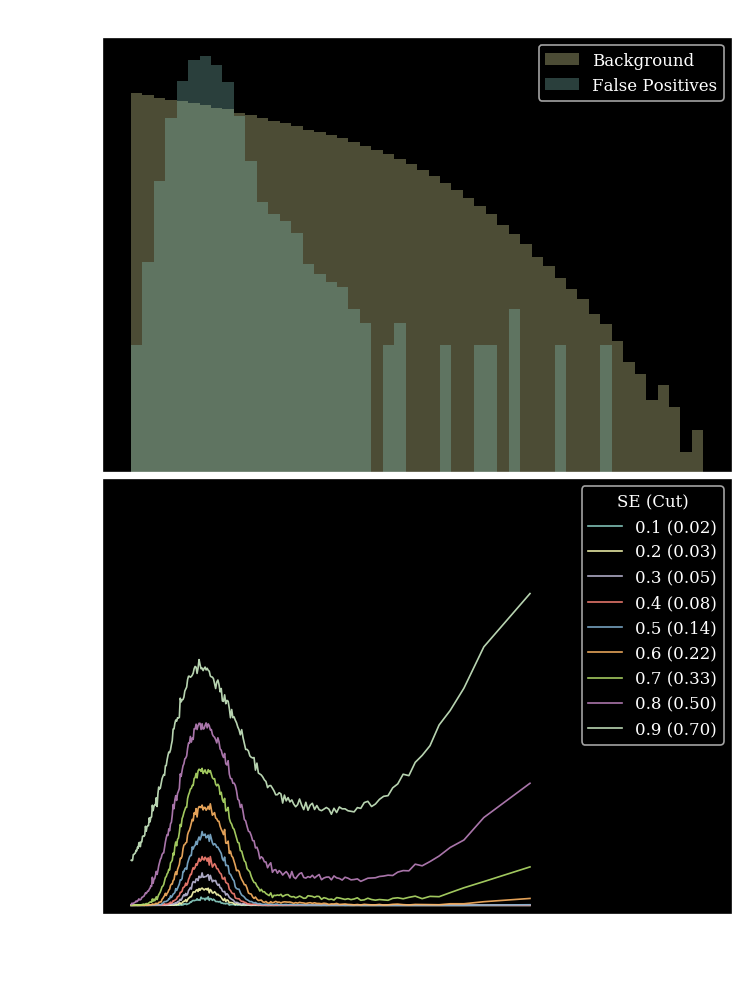

strength 50
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (393.4s)
 Train: loss:0.3861, acc:66% || Val: loss: 0.1095, acc:83%, R50: 10.1905, 1/JSD: 15.3196


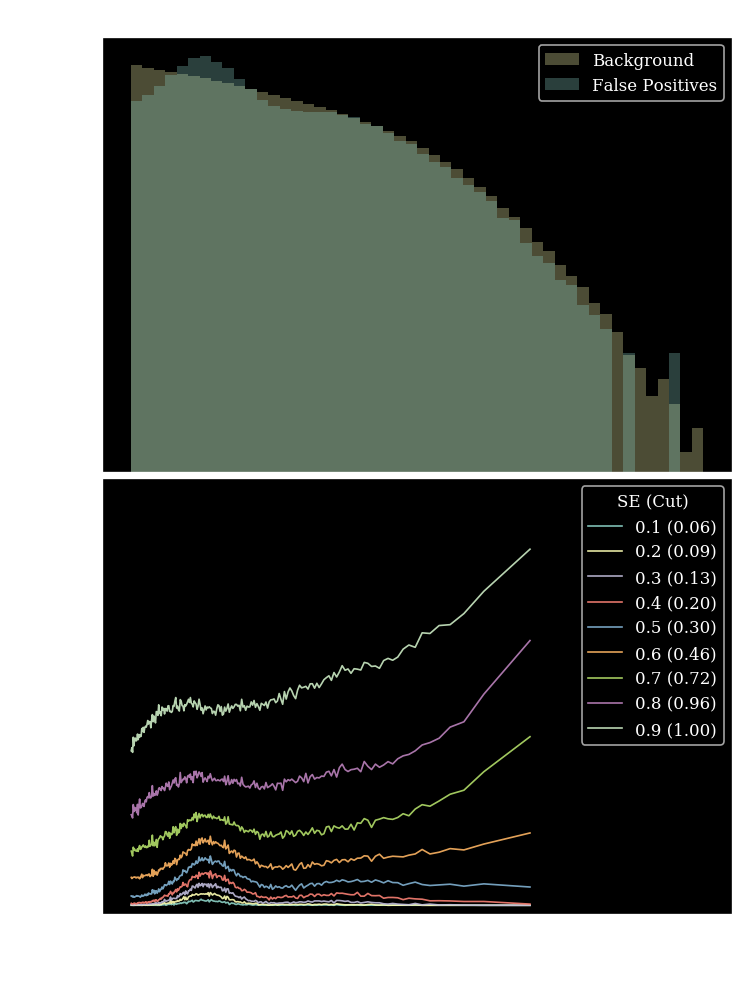

strength 50
Entering Training...
Epoch:0001/0200  (8.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (397.4s)
 Train: loss:0.4068, acc:65% || Val: loss: 0.1153, acc:84%, R50: 10.4239, 1/JSD: 15.4955


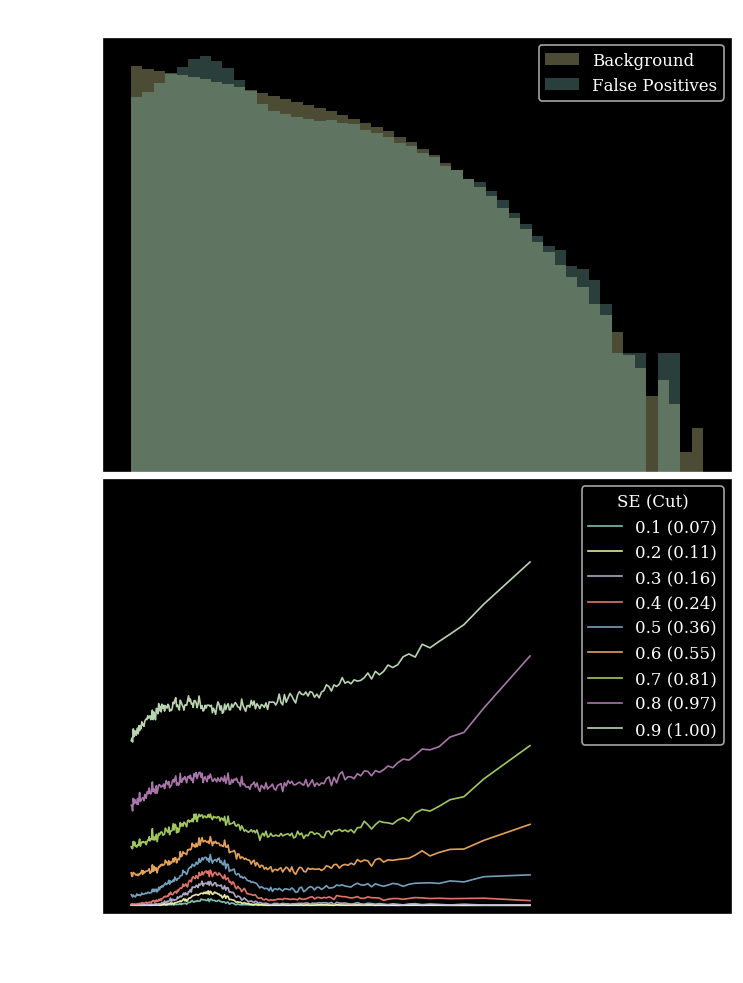

strength 50
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (406.4s)
 Train: loss:0.5046, acc:54% || Val: loss: 0.1457, acc:84%, R50: 12.4938, 1/JSD: 14.1972


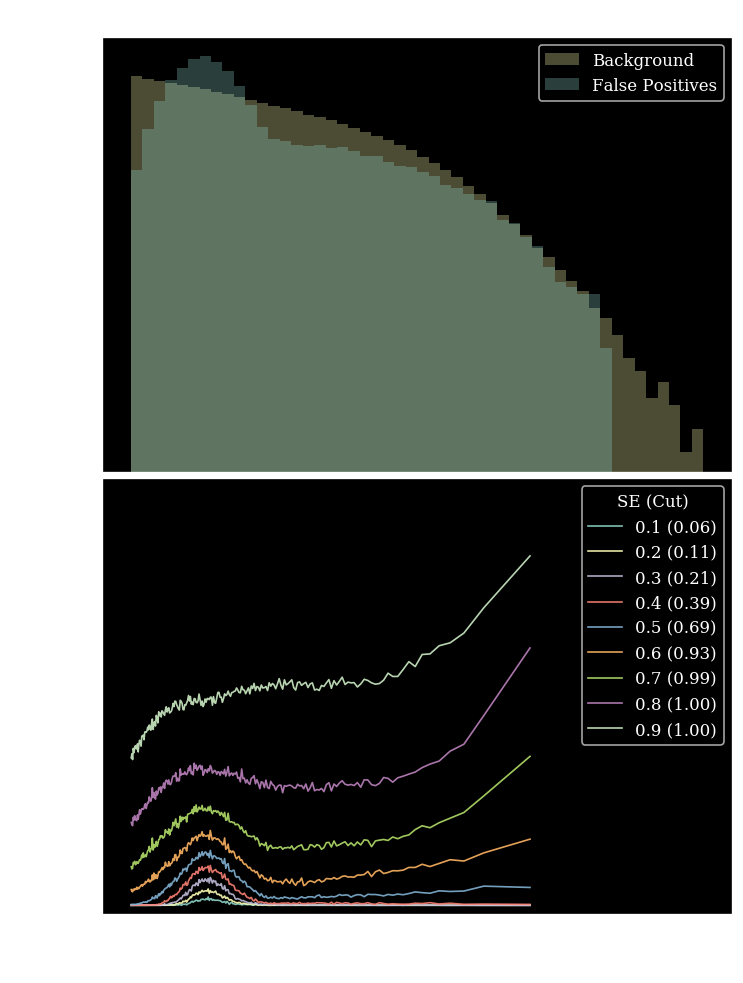

strength 60
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (392.2s)
 Train: loss:0.3995, acc:65% || Val: loss: 0.1137, acc:83%, R50: 10.0496, 1/JSD: 14.2504


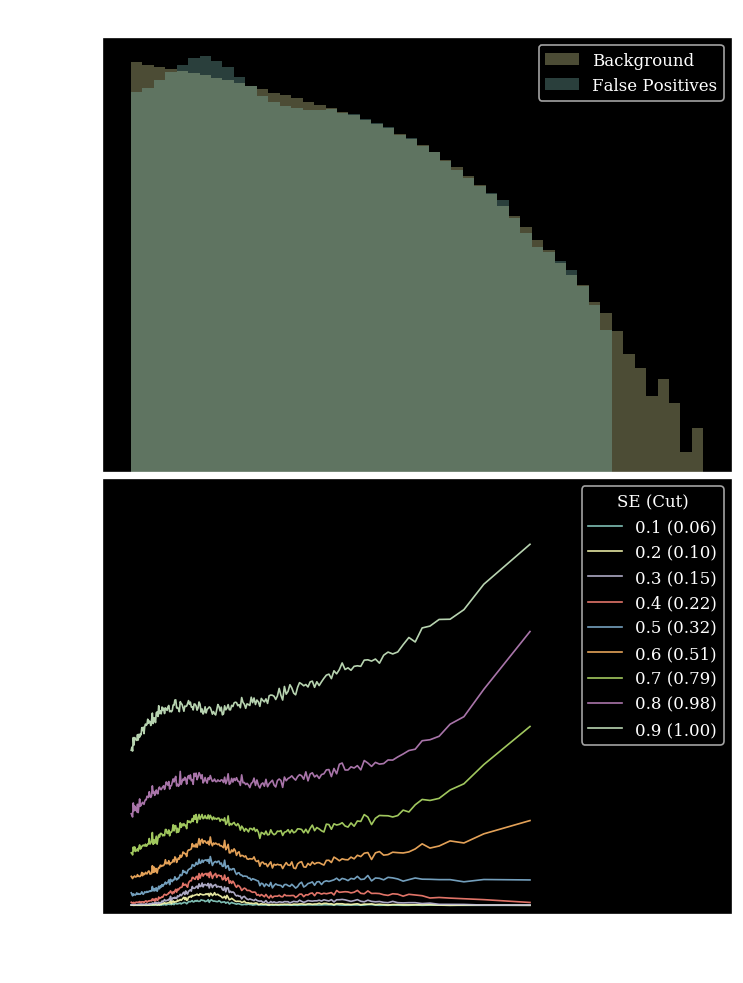

strength 60
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (393.9s)
 Train: loss:0.4265, acc:62% || Val: loss: 0.1207, acc:84%, R50: 10.4553, 1/JSD: 16.3055


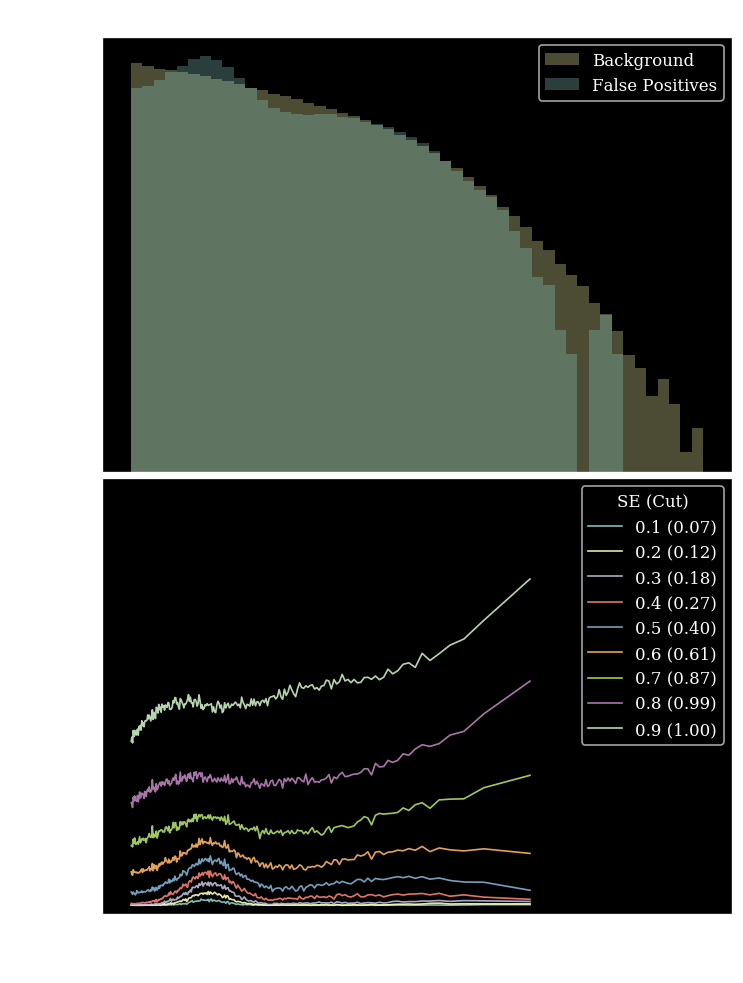

strength 60
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (392.3s)
 Train: loss:0.5345, acc:52% || Val: loss: 0.1525, acc:83%, R50: 12.5935, 1/JSD: 12.5570


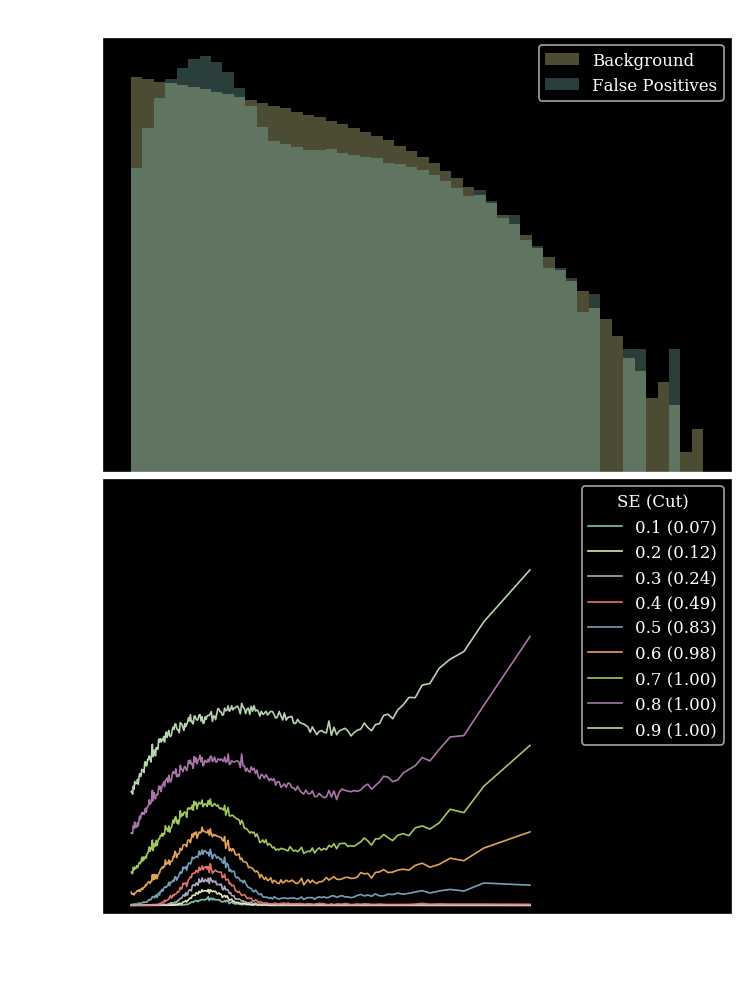

strength 75
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (386.8s)
 Train: loss:0.4154, acc:64% || Val: loss: 0.1190, acc:83%, R50: 9.9290, 1/JSD: 14.3173


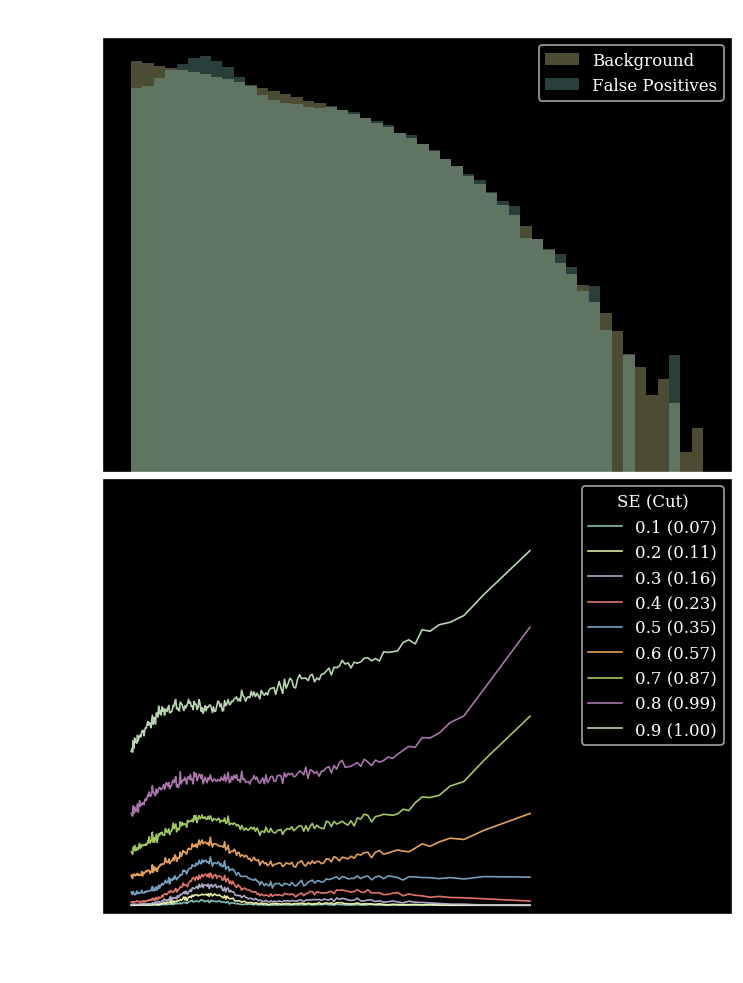

strength 75
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (389.8s)
 Train: loss:0.4491, acc:60% || Val: loss: 0.1280, acc:83%, R50: 10.3555, 1/JSD: 17.3577


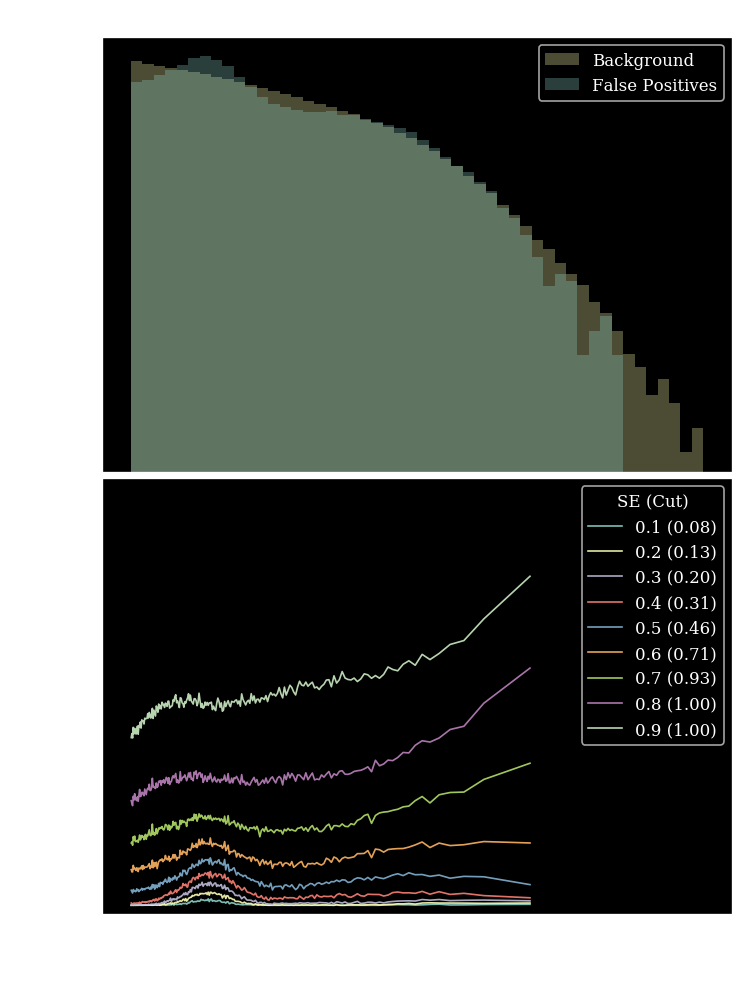

strength 75
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (388.3s)
 Train: loss:0.5399, acc:50% || Val: loss: 0.1594, acc:83%, R50: 12.7843, 1/JSD: 7.5692


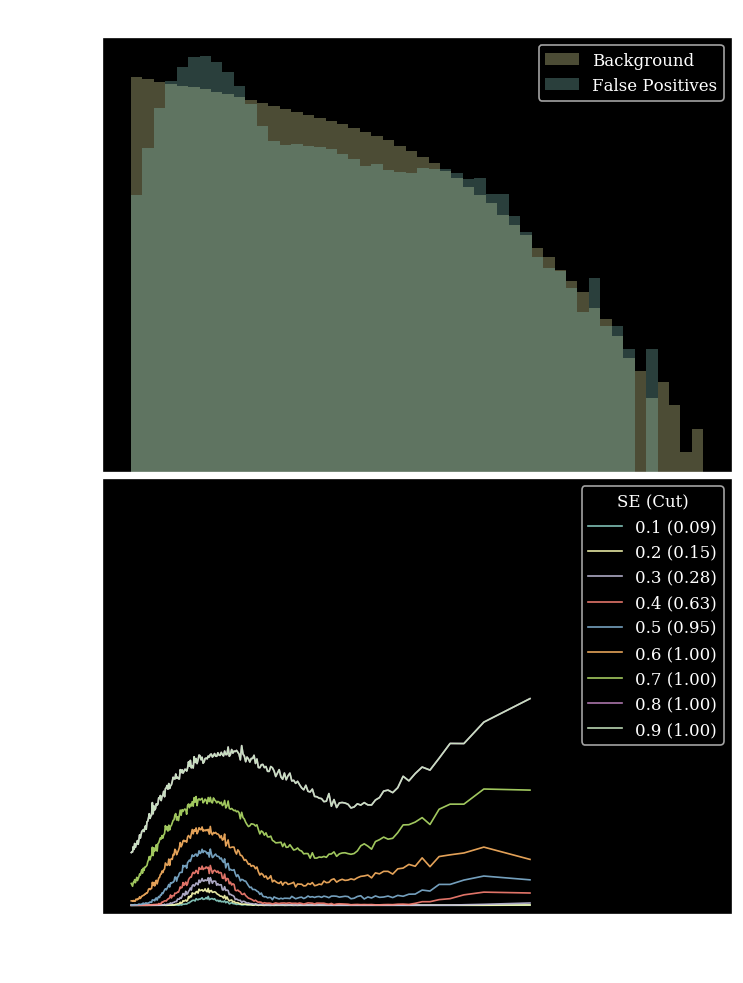

strength 85
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (392.1s)
 Train: loss:0.4232, acc:63% || Val: loss: 0.1217, acc:83%, R50: 9.9463, 1/JSD: 13.5151


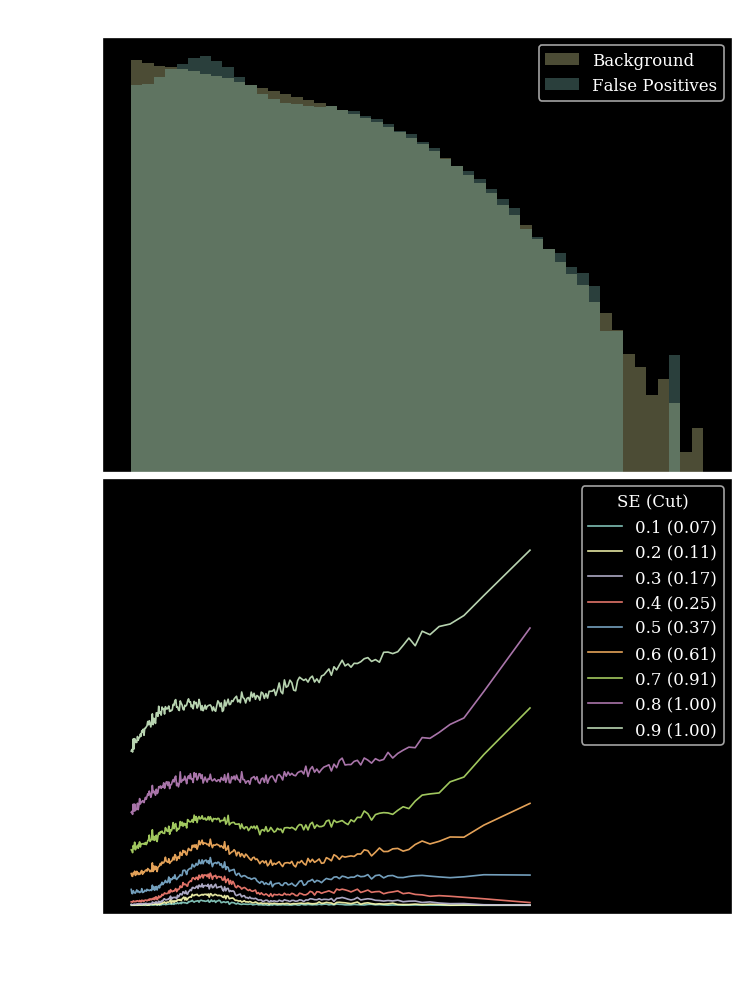

strength 85
Entering Training...
Epoch:0001/0200  (8.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (400.0s)
 Train: loss:0.4752, acc:59% || Val: loss: 0.1320, acc:83%, R50: 10.4055, 1/JSD: 17.1798


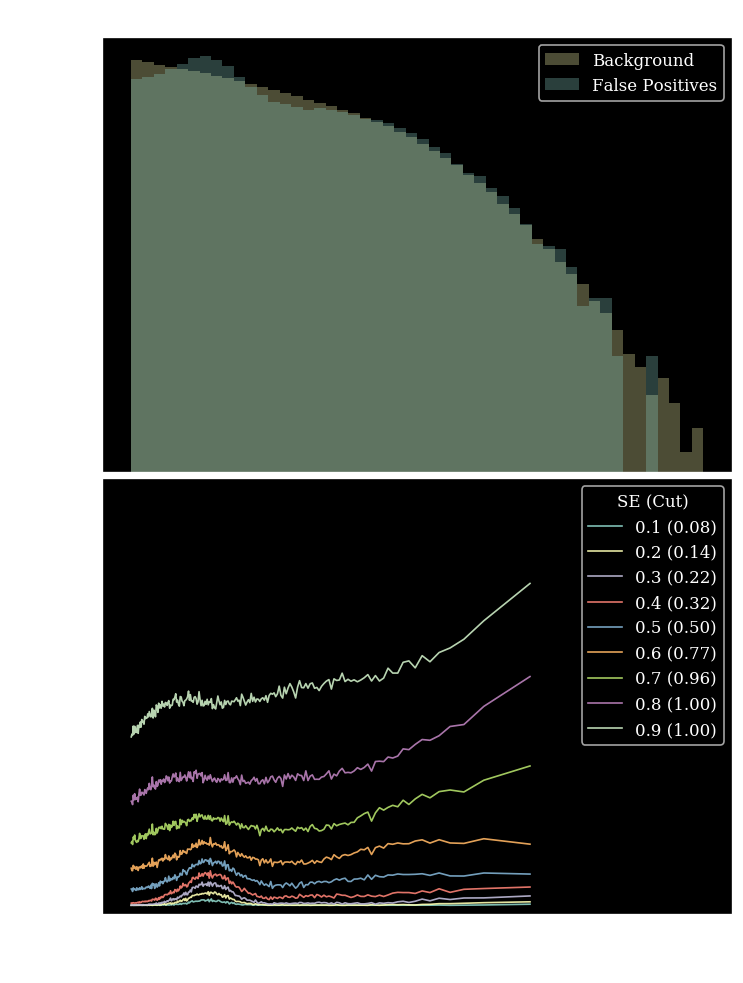

strength 85
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (395.3s)
 Train: loss:0.5547, acc:49% || Val: loss: 0.1617, acc:83%, R50: 13.3387, 1/JSD: 6.5245


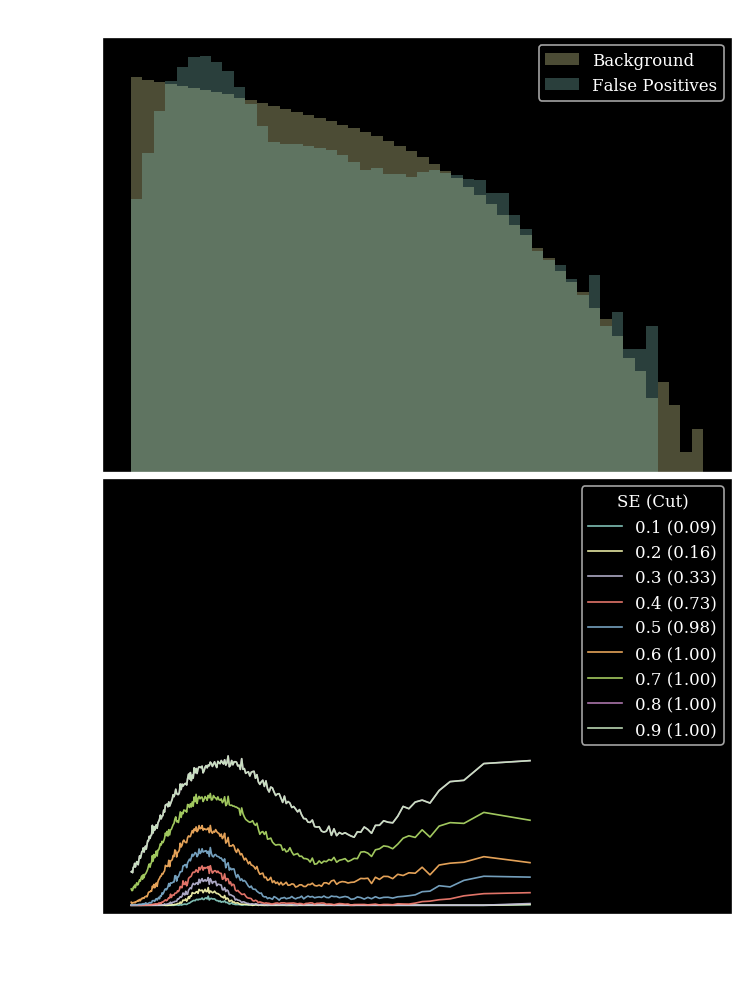

strength 100
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (388.8s)
 Train: loss:0.4337, acc:61% || Val: loss: 0.1262, acc:83%, R50: 9.7961, 1/JSD: 13.1342


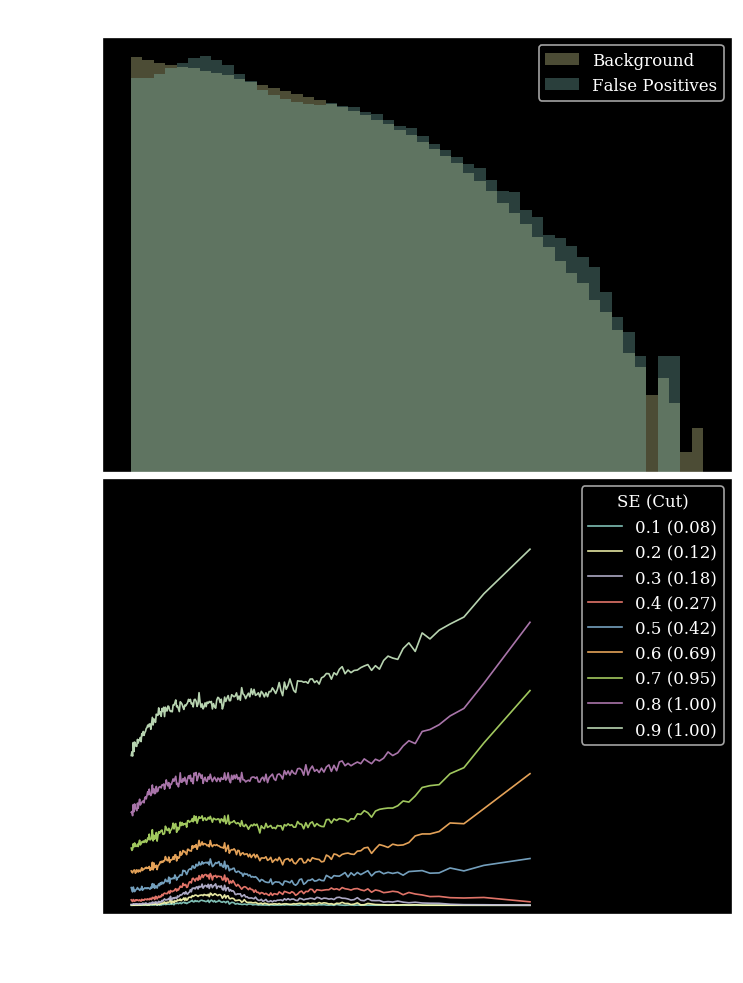

strength 100
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (390.0s)
 Train: loss:0.4735, acc:56% || Val: loss: 0.1374, acc:83%, R50: 10.1720, 1/JSD: 16.8219


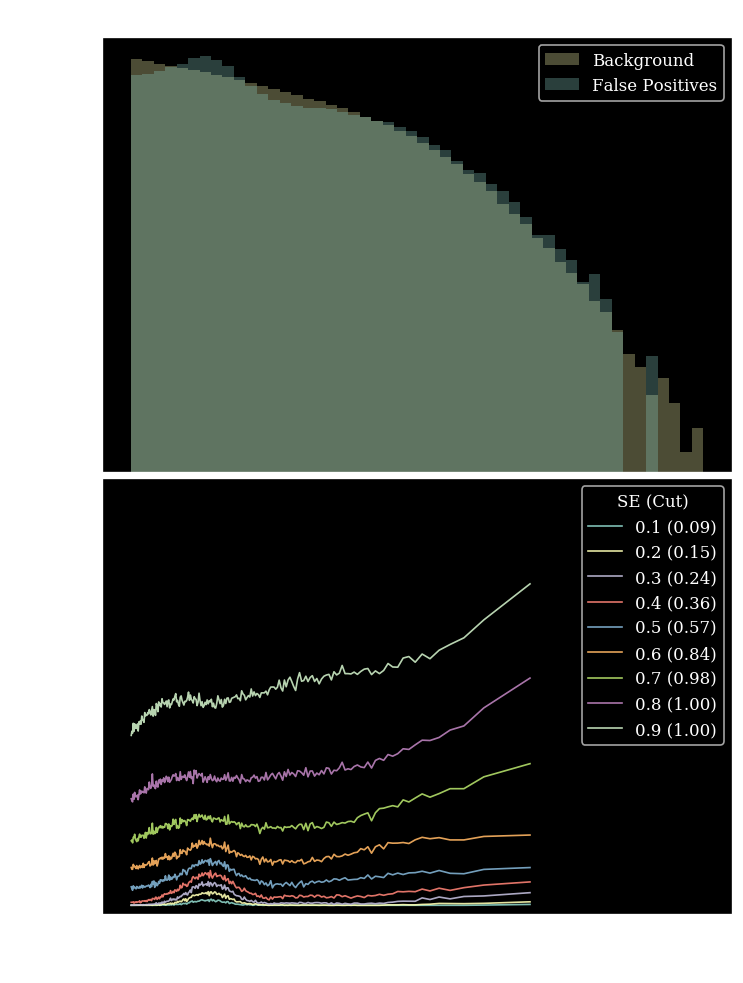

strength 100
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (392.3s)
 Train: loss:0.5666, acc:48% || Val: loss: 0.1662, acc:83%, R50: 16.8763, 1/JSD: 3.6914


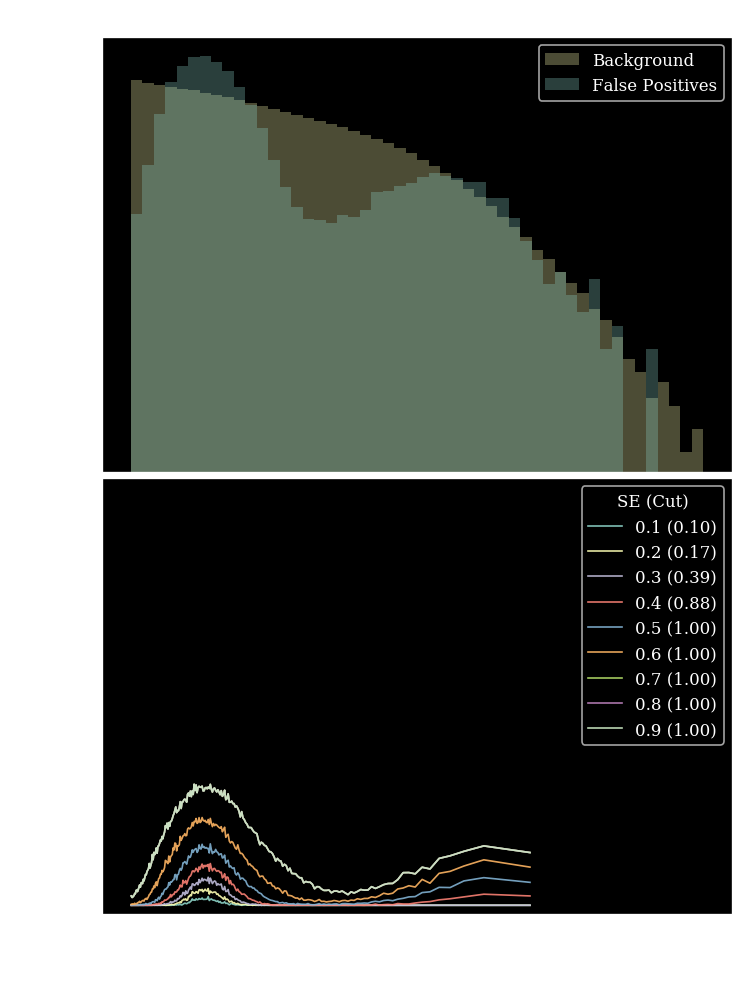

strength 110
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (395.0s)
 Train: loss:0.4456, acc:60% || Val: loss: 0.1283, acc:83%, R50: 9.9031, 1/JSD: 14.9041


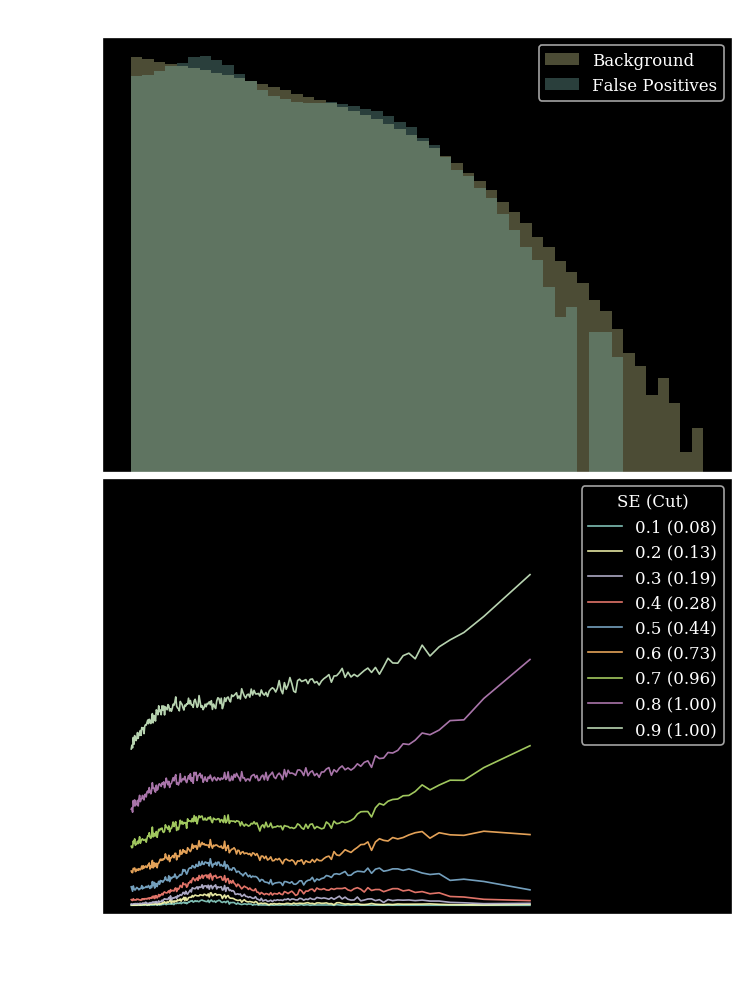

strength 110
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (388.8s)
 Train: loss:0.4793, acc:56% || Val: loss: 0.1412, acc:83%, R50: 10.1476, 1/JSD: 17.7268


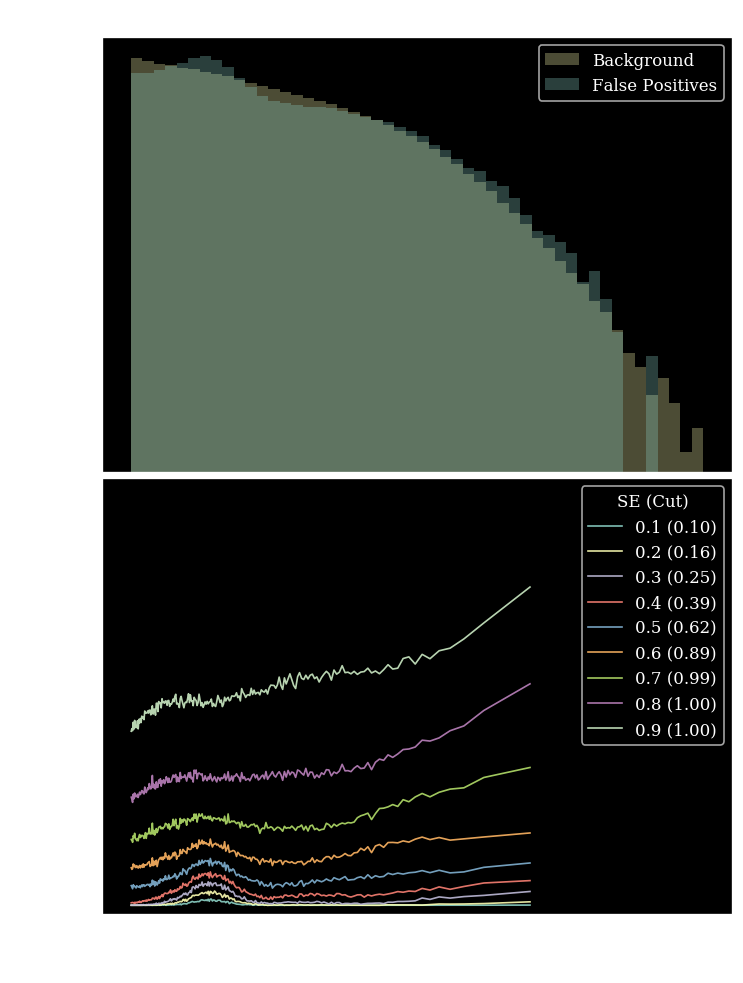

strength 110
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (397.4s)
 Train: loss:0.5805, acc:47% || Val: loss: 0.1675, acc:83%, R50: 18.1259, 1/JSD: 3.3336


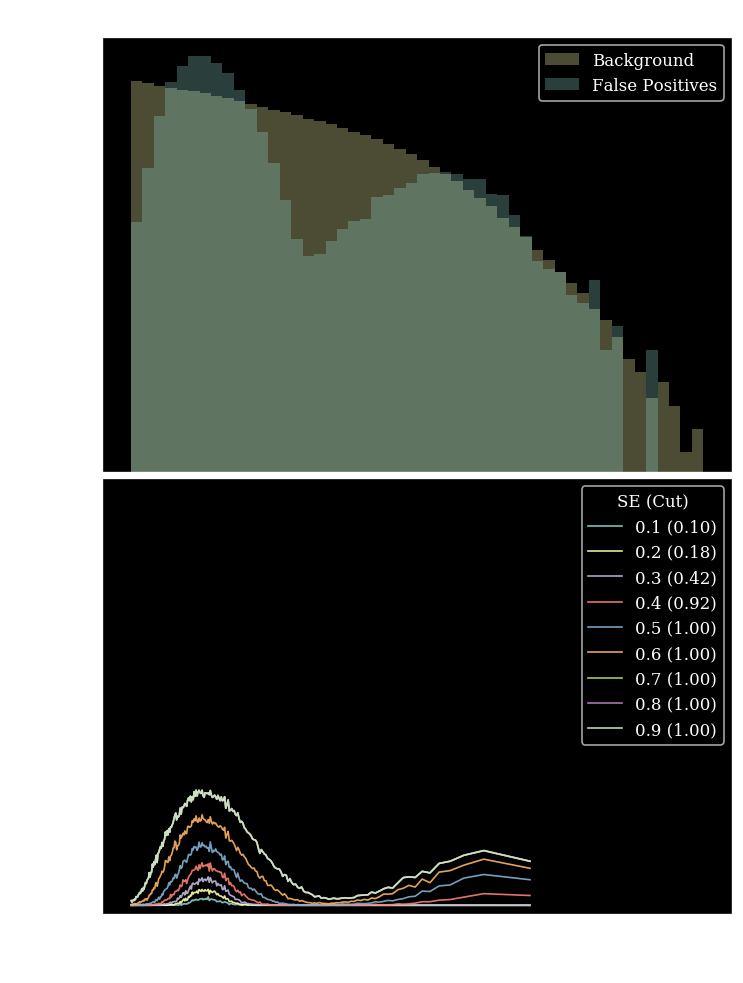

strength 120
Entering Training...
Epoch:0001/0200  (8.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (392.5s)
 Train: loss:0.4632, acc:59% || Val: loss: 0.1307, acc:83%, R50: 9.8770, 1/JSD: 15.5901


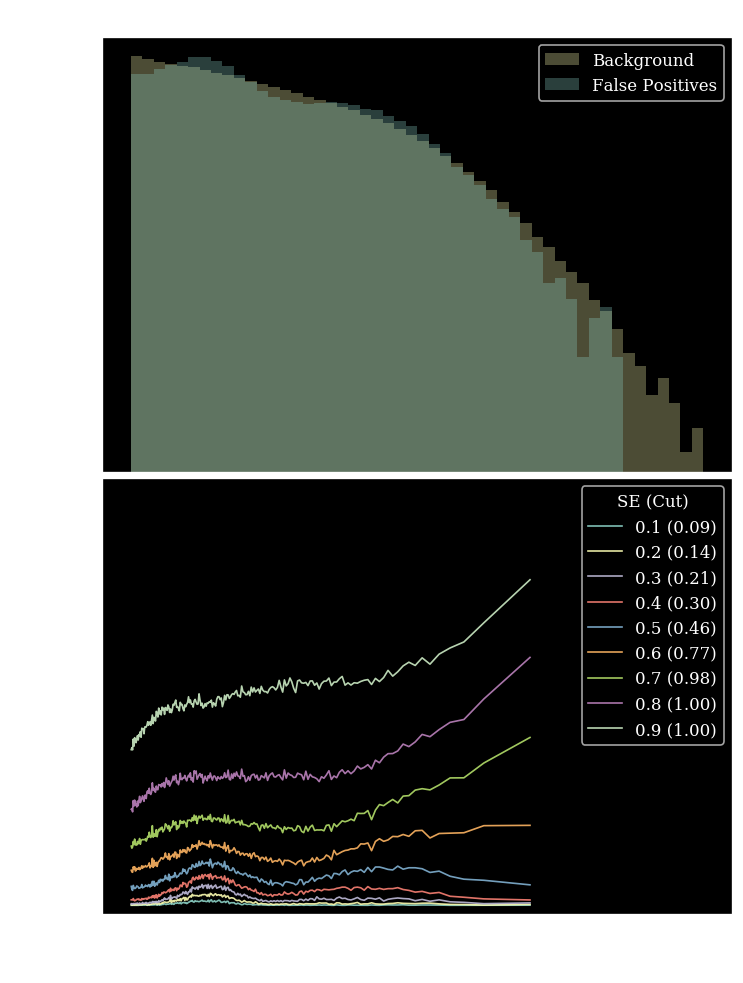

strength 120
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (389.7s)
 Train: loss:0.4846, acc:55% || Val: loss: 0.1434, acc:83%, R50: 10.1523, 1/JSD: 16.0497


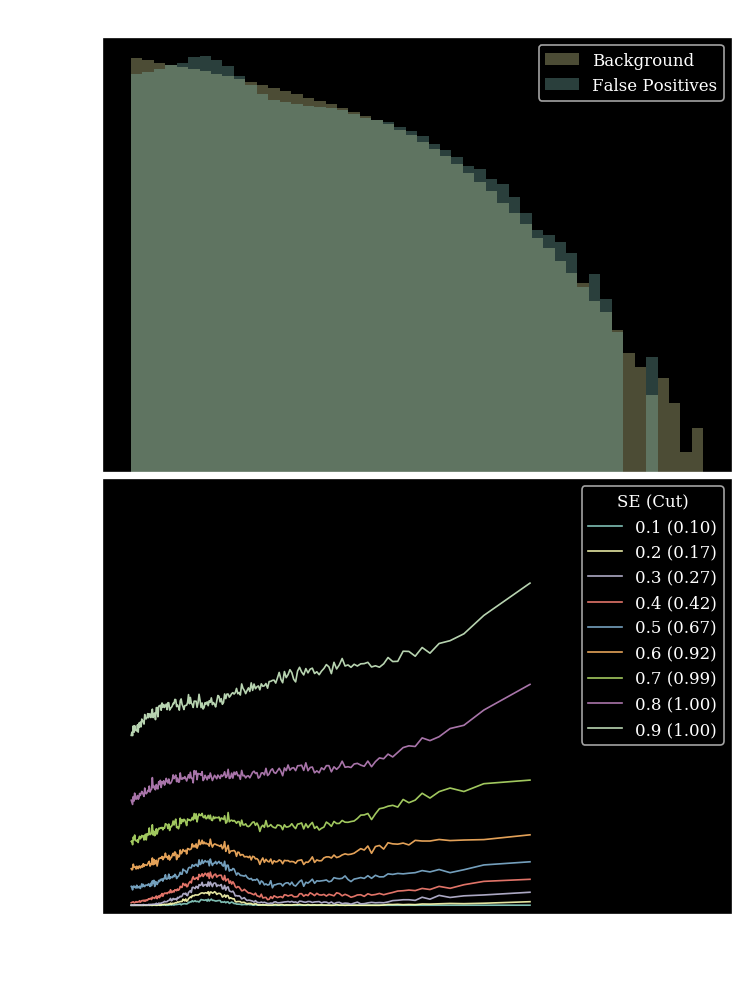

strength 120
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (394.5s)
 Train: loss:0.5863, acc:47% || Val: loss: 0.1681, acc:82%, R50: 19.8544, 1/JSD: 2.5798


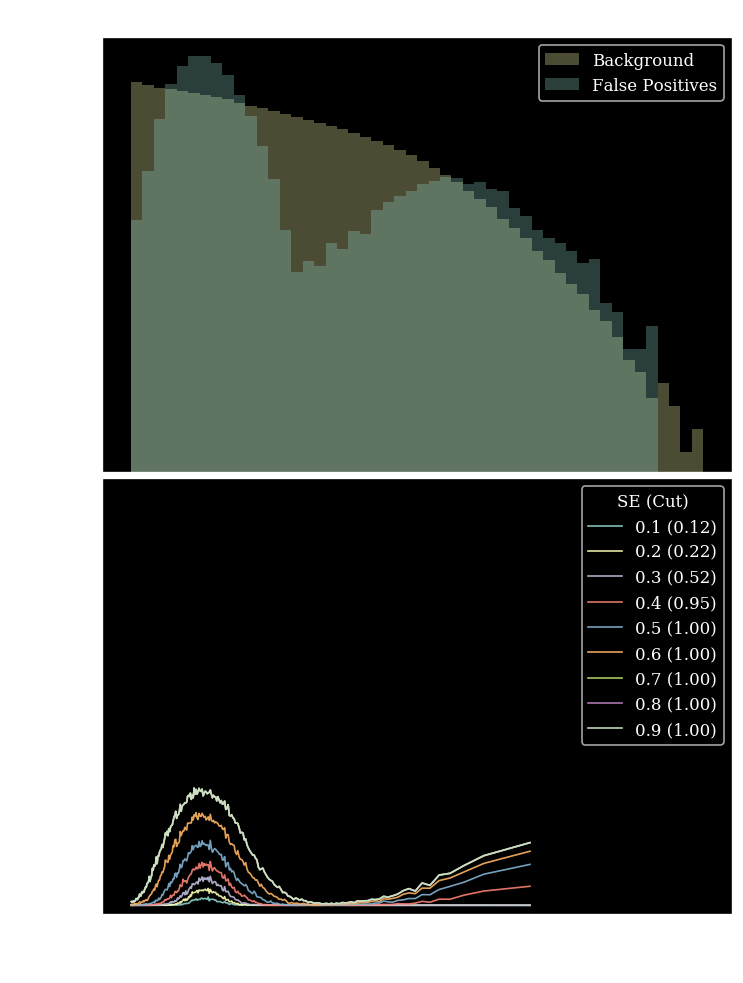

strength 200
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (400.5s)
 Train: loss:0.4920, acc:54% || Val: loss: 0.1444, acc:83%, R50: 9.9182, 1/JSD: 20.3363


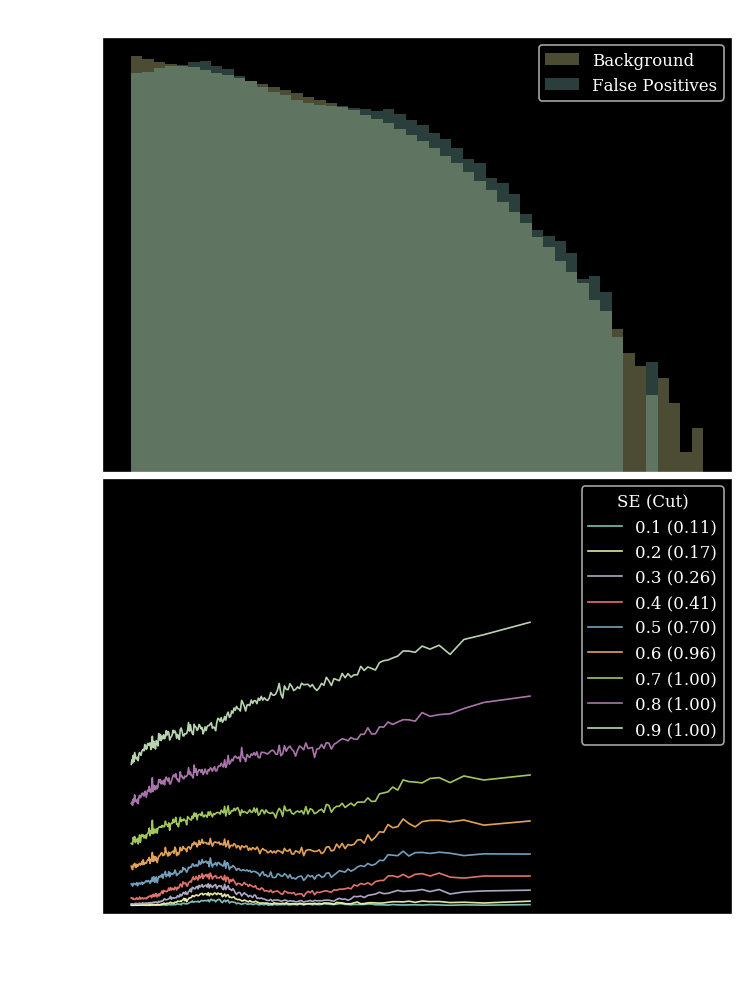

strength 200
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (399.2s)
 Train: loss:0.5481, acc:48% || Val: loss: 0.1601, acc:82%, R50: 9.9967, 1/JSD: 16.8420


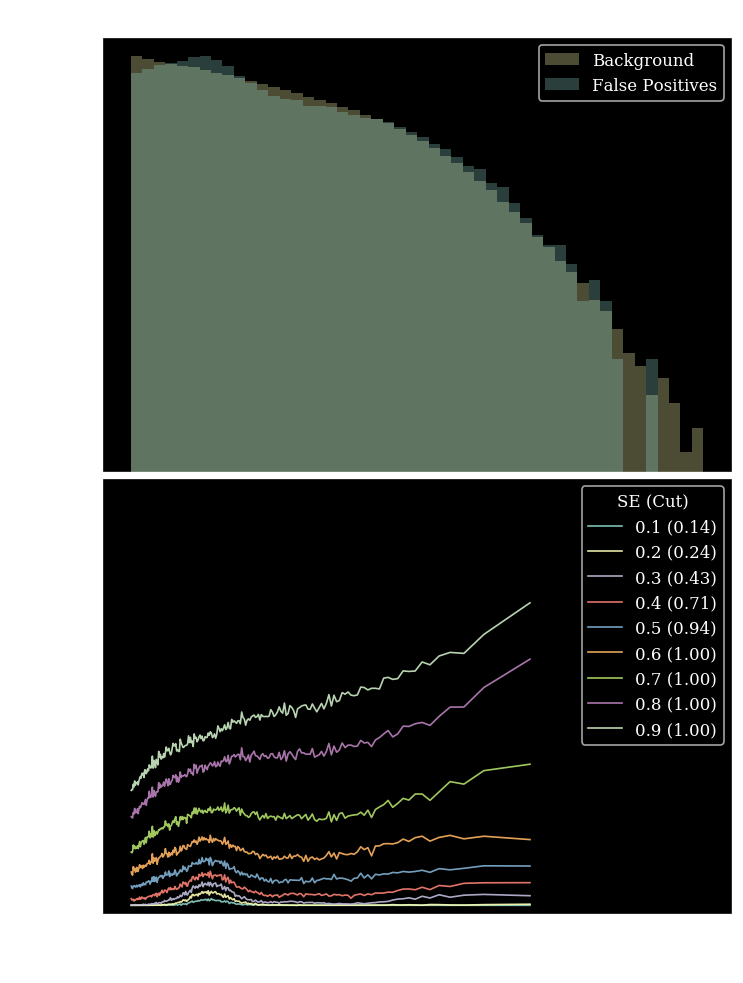

strength 200
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (390.6s)
 Train: loss:0.6639, acc:42% || Val: loss: 0.1750, acc:82%, R50: 29.3464, 1/JSD: 2.5497


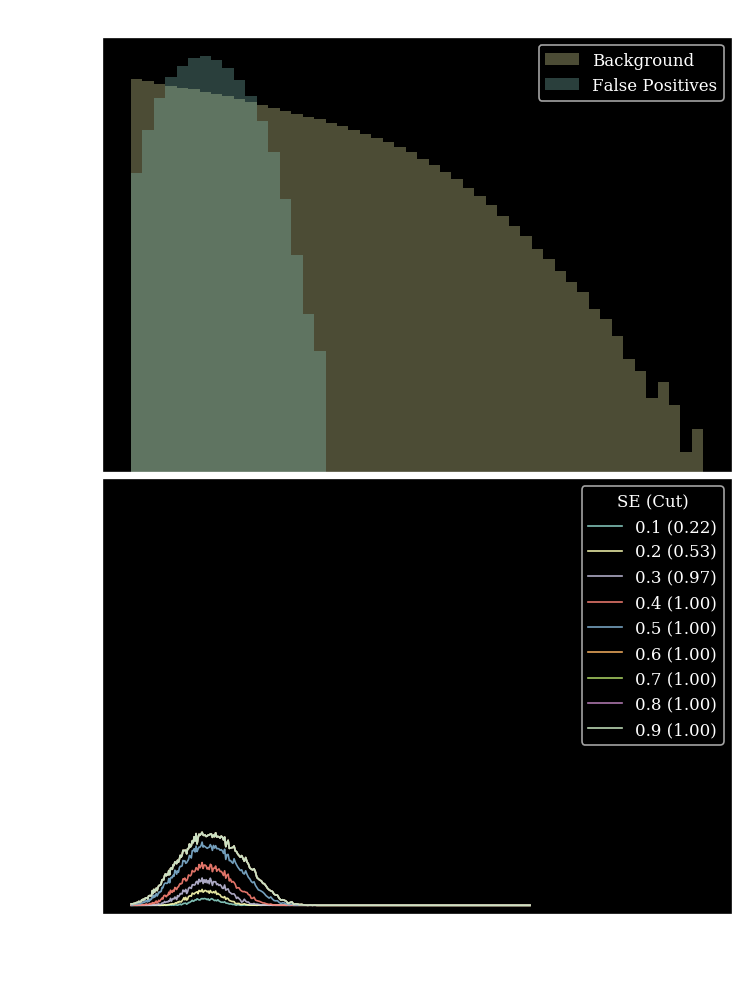

strength 500
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (386.9s)
 Train: loss:0.5900, acc:45% || Val: loss: 0.1676, acc:82%, R50: 9.7173, 1/JSD: 32.4748


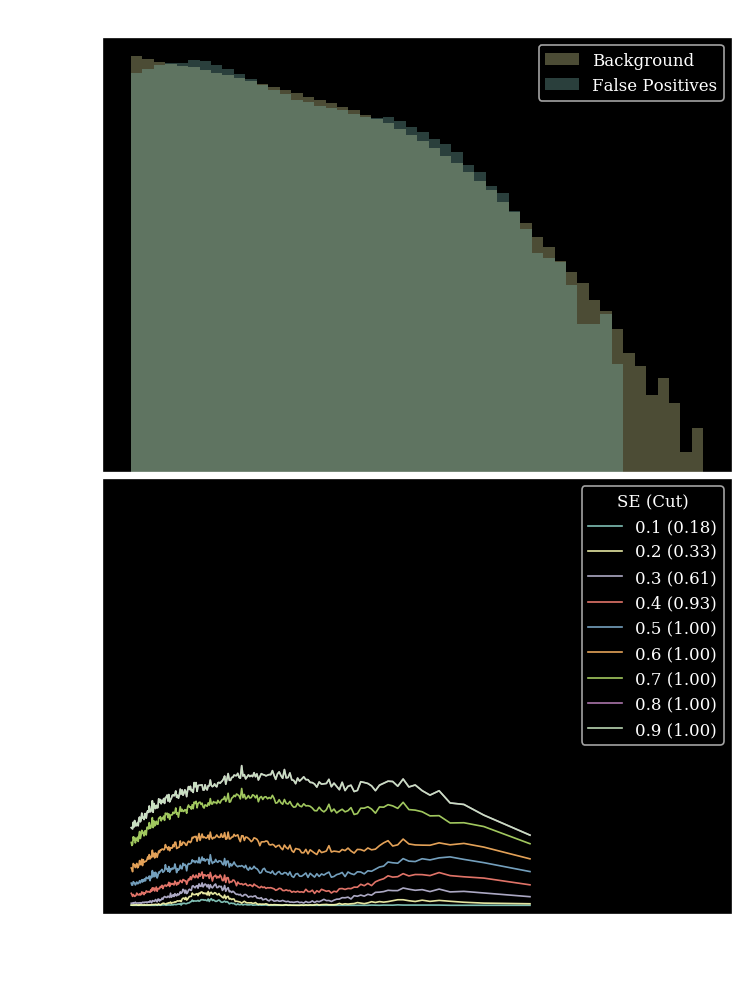

strength 500
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (391.7s)
 Train: loss:0.6411, acc:40% || Val: loss: 0.1748, acc:82%, R50: 20.2367, 1/JSD: 5.5731


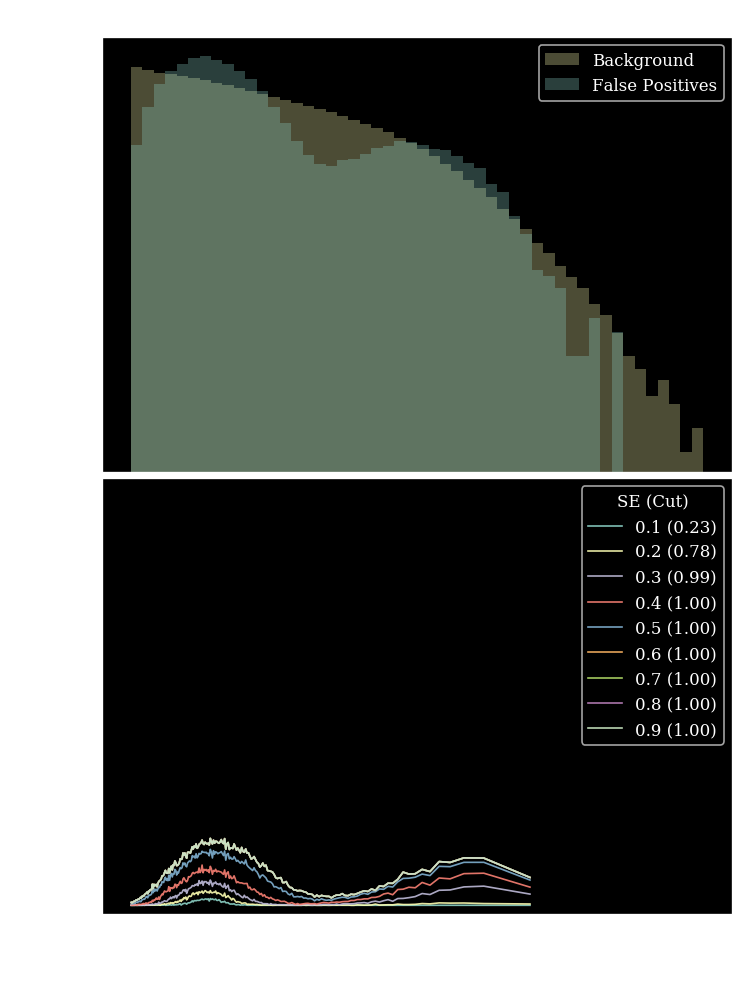

strength 500
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (394.5s)
 Train: loss:0.7036, acc:30% || Val: loss: 0.1951, acc:80%, R50: 9166.6667, 1/JSD: 4.3461


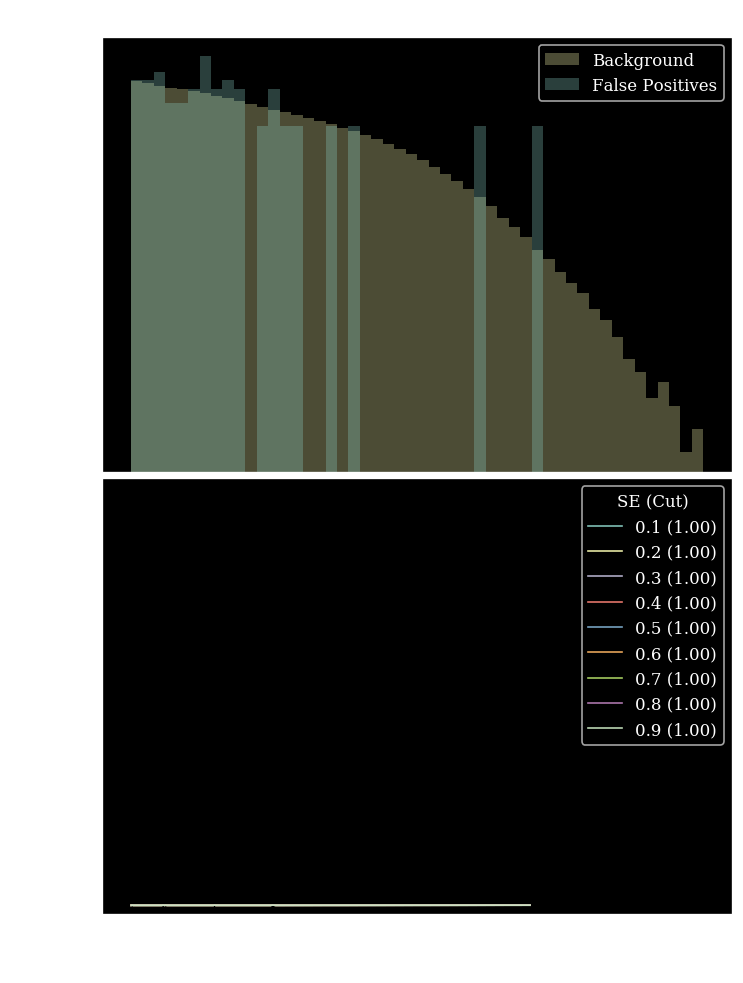

strength 1000
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (399.2s)
 Train: loss:0.6690, acc:38% || Val: loss: 0.1753, acc:82%, R50: 19.0785, 1/JSD: 7.9030


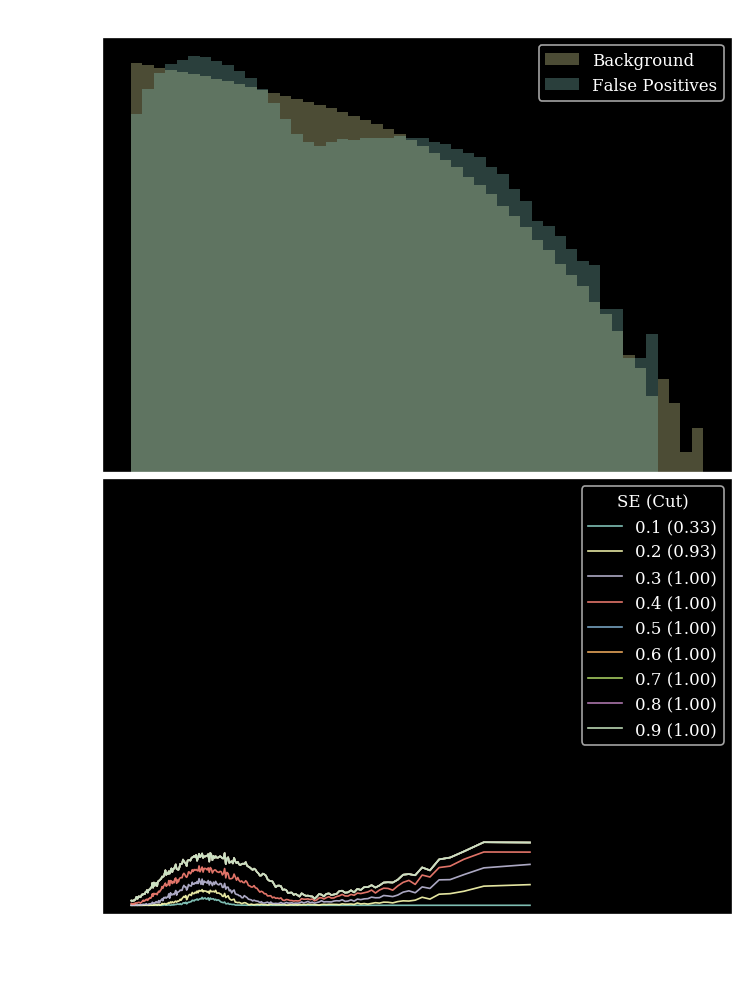

strength 1000
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (396.7s)
 Train: loss:0.7154, acc:32% || Val: loss: 0.1847, acc:81%, R50: 23.3546, 1/JSD: 4.1088


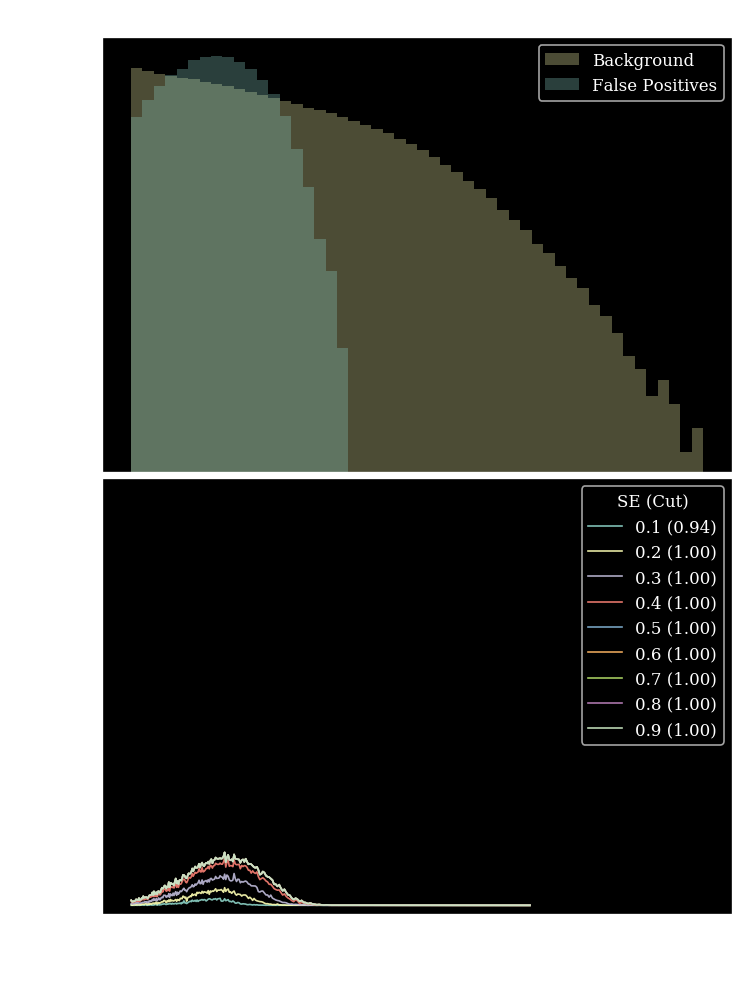

strength 1000
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (404.2s)
 Train: loss:0.7036, acc:30% || Val: loss: 0.1951, acc:80%, R50: 11379.3103, 1/JSD: 3.4075


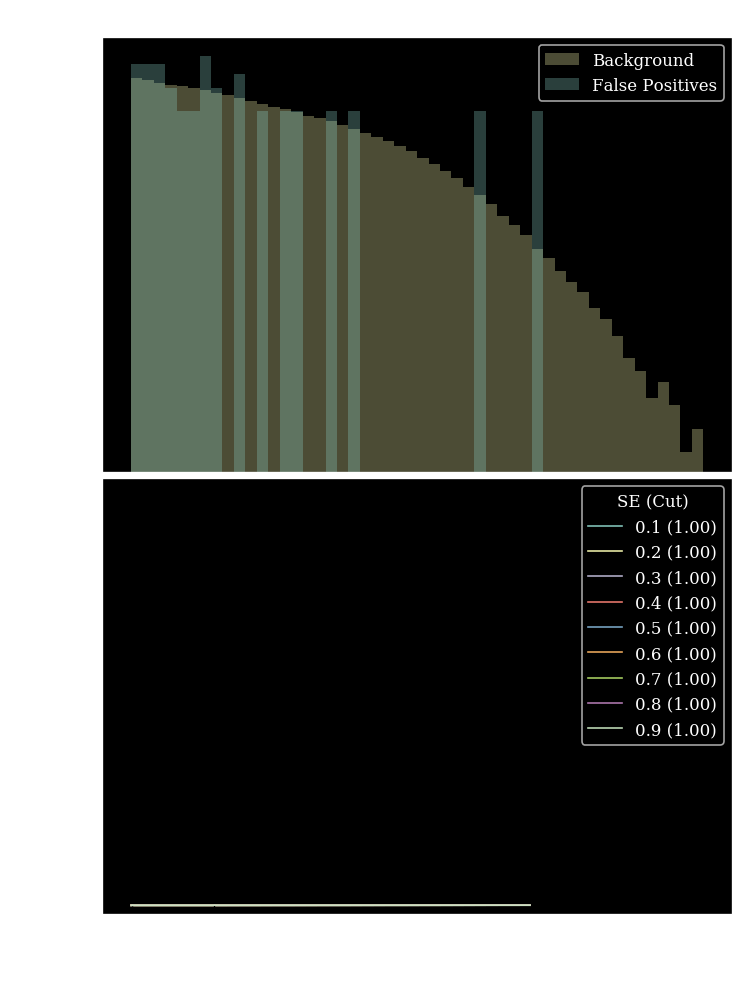

In [8]:
jsdR50flatstr = []
for i,frac in enumerate([1,50,60,75,85,100,110,120,200,500,1000]):
    for bins in [5,10,32]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=False)
        log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,
                       y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
        jsdR50flatstr.append(out)

# DisCo str

strength 1
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (815.6s)
 Train: loss:0.2066, acc:79% || Val: loss: 0.0603, acc:84%, R50: 22.4352, 1/JSD: 2.4299


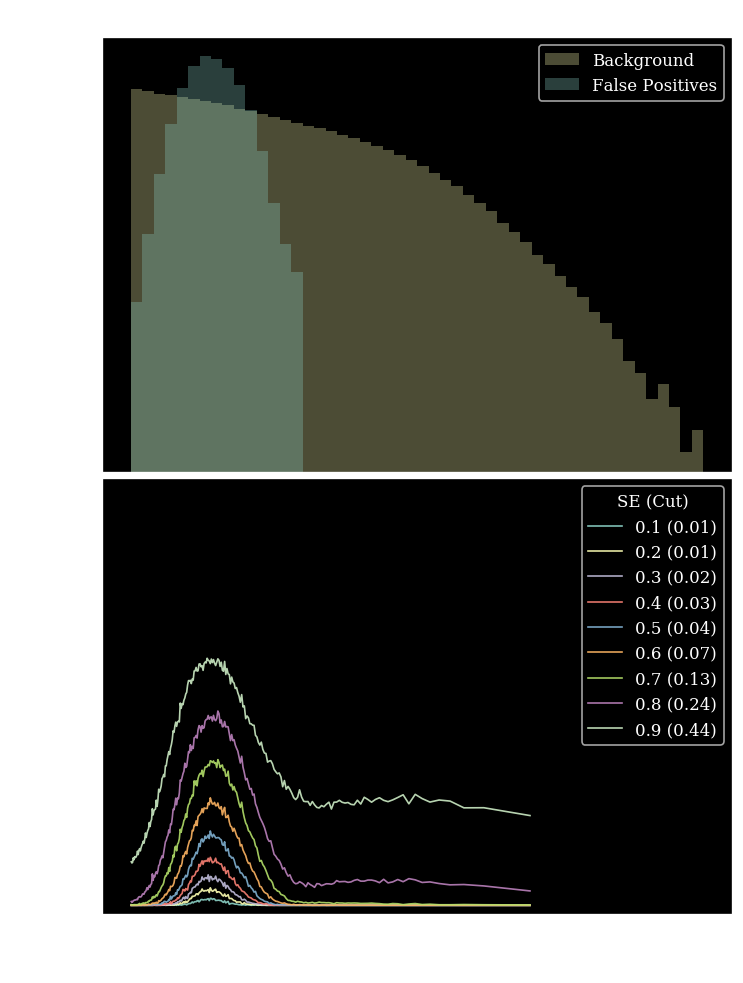

strength 2
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (817.9s)
 Train: loss:0.2205, acc:78% || Val: loss: 0.0627, acc:82%, R50: 18.9112, 1/JSD: 4.7060


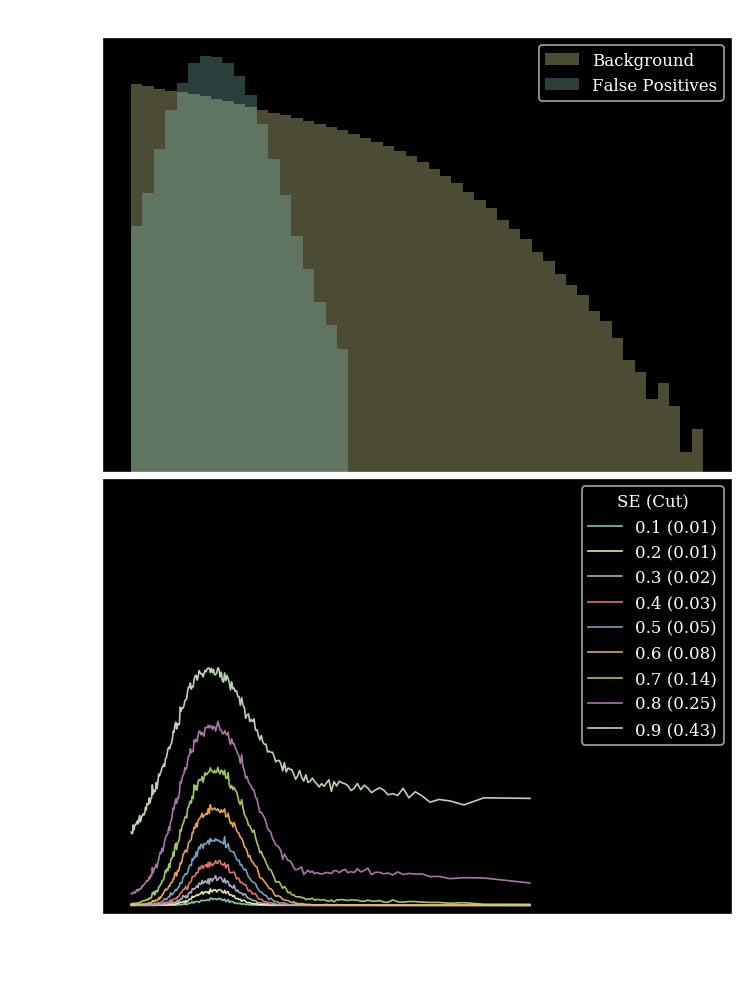

strength 5
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (852.6s)
 Train: loss:0.2393, acc:78% || Val: loss: 0.0656, acc:81%, R50: 14.6804, 1/JSD: 15.4360


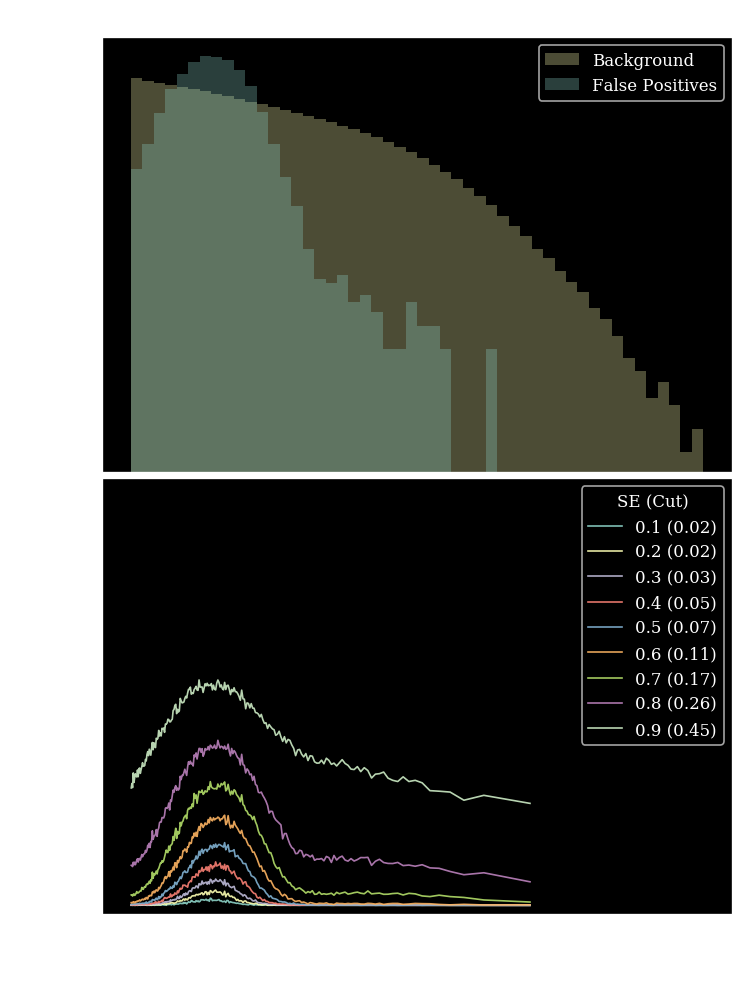

strength 10
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (853.1s)
 Train: loss:0.2571, acc:77% || Val: loss: 0.0669, acc:79%, R50: 12.5194, 1/JSD: 29.1968


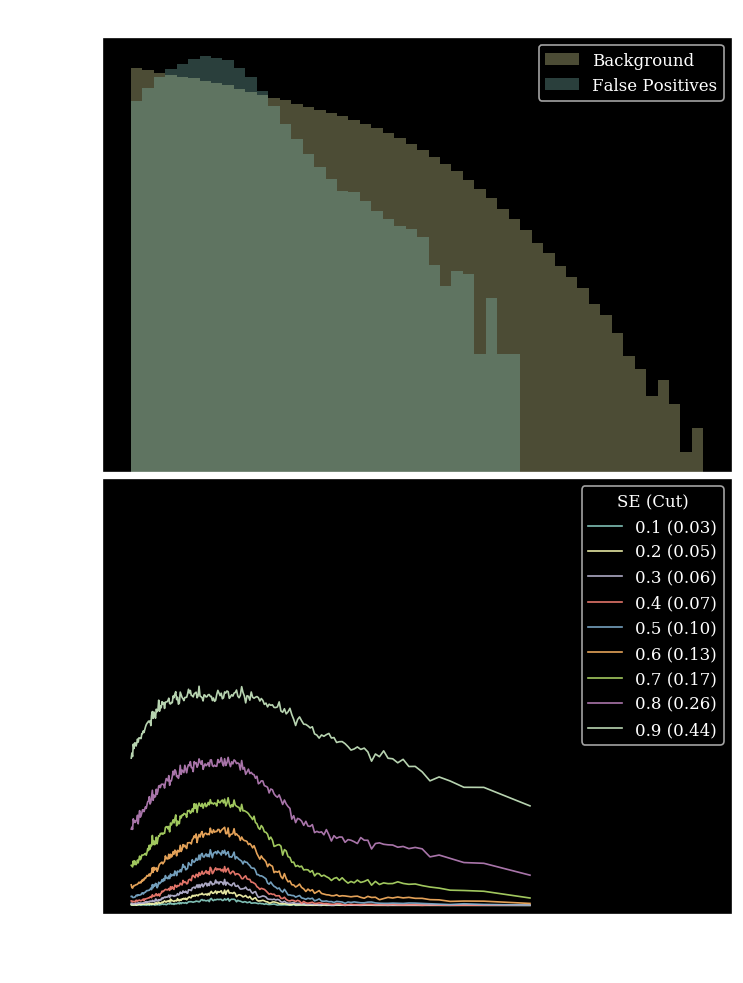

strength 20
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (858.4s)
 Train: loss:0.3202, acc:76% || Val: loss: 0.0702, acc:77%, R50: 10.5293, 1/JSD: 119.6289


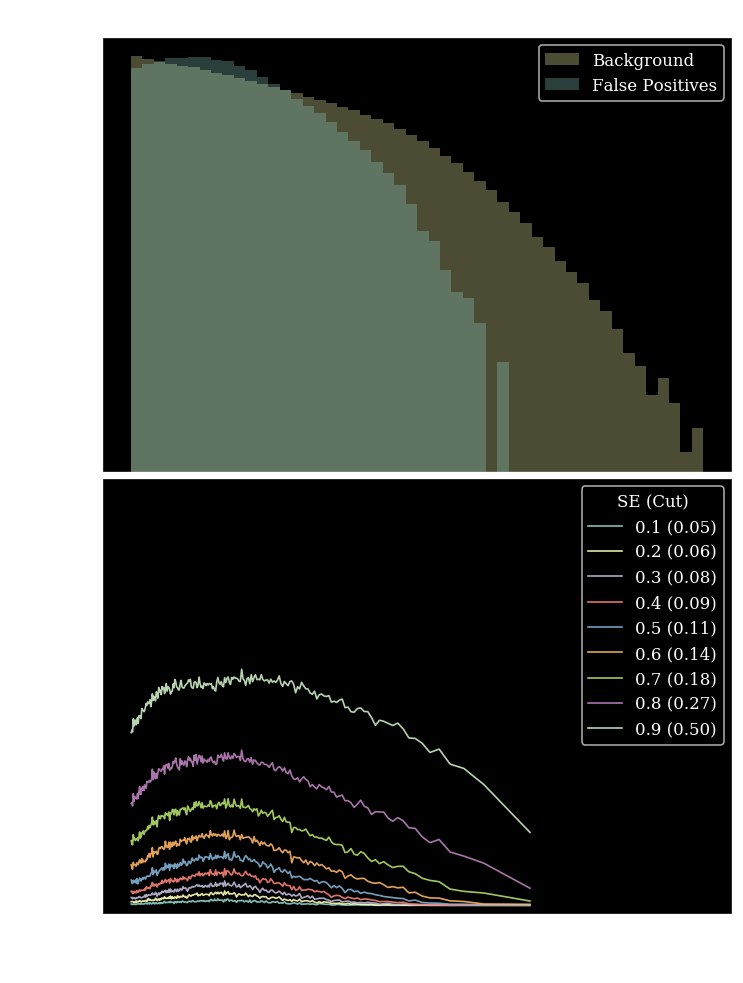

strength 30
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (863.9s)
 Train: loss:0.3658, acc:73% || Val: loss: 0.0733, acc:76%, R50: 9.7179, 1/JSD: 141.7120


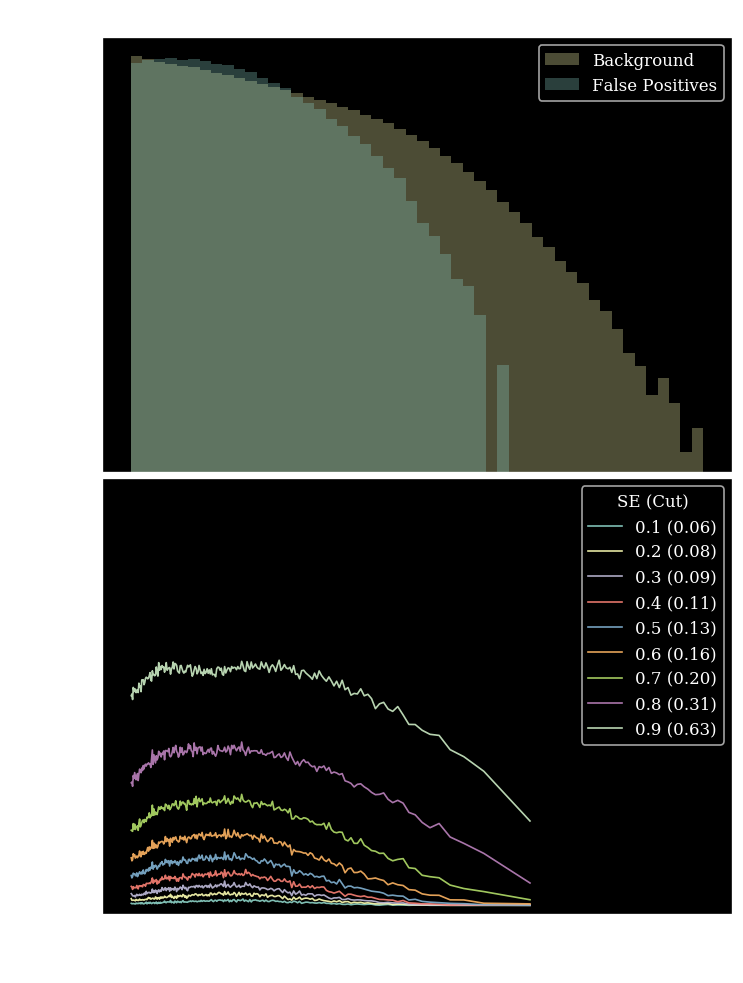

strength 50
Entering Training...
Epoch:0001/0200  (8.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (866.4s)
 Train: loss:0.4009, acc:69% || Val: loss: 0.0767, acc:77%, R50: 8.9329, 1/JSD: 217.4372


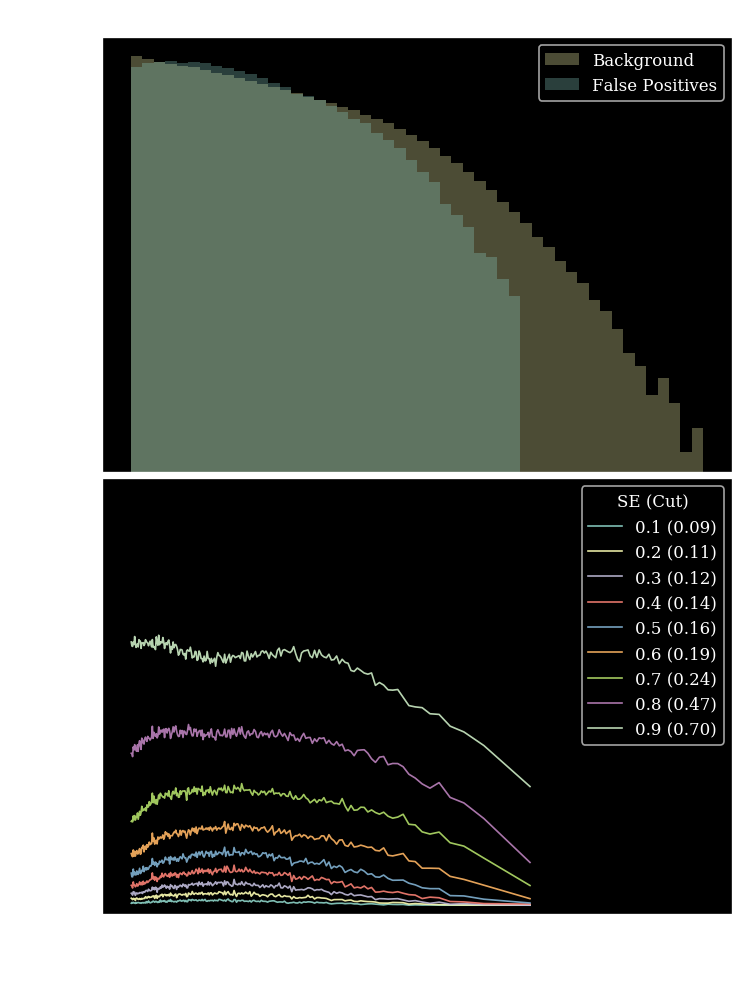

strength 100
Entering Training...
Epoch:0001/0200  (9.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (862.0s)
 Train: loss:0.4224, acc:63% || Val: loss: 0.0862, acc:72%, R50: 5.2524, 1/JSD: 446.9971


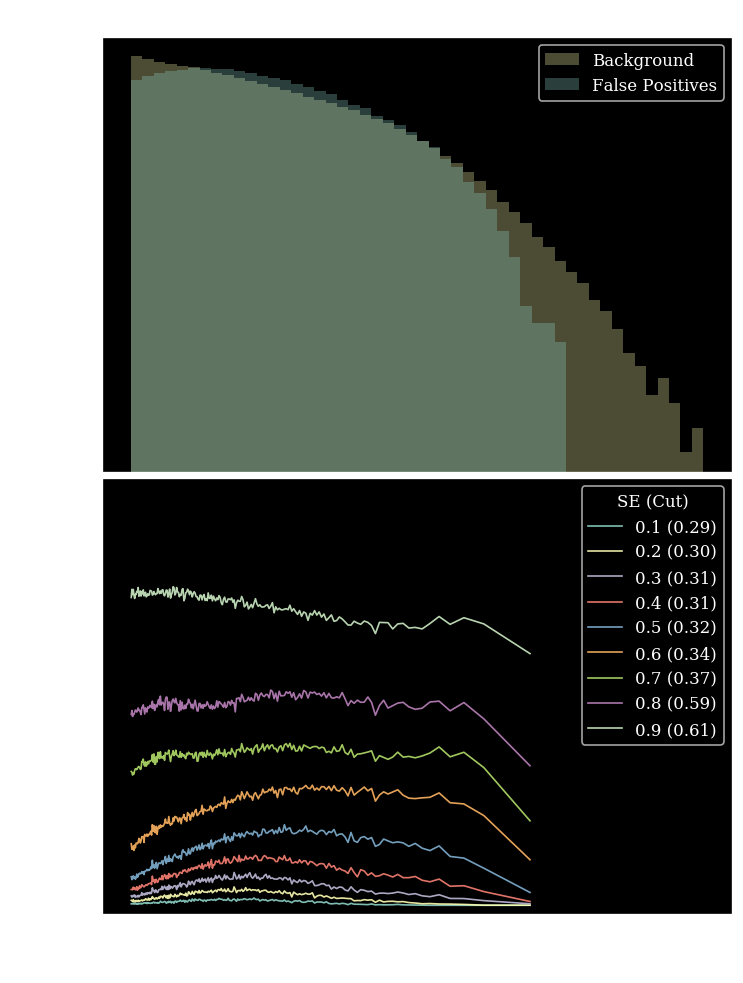

In [9]:
jsdR50Disco = []
for i,frac in enumerate([1,2,5,10,20,30,50,100]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    log=Logger("./logs/logWFCNDisLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"DisCo DNN str:{frac}",X=X,
                   y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
    jsdR50Disco.append(out)

strength 200
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (811.8s)
 Train: loss:0.8784, acc:51% || Val: loss: 0.0956, acc:63%, R50: 2.7830, 1/JSD: 1632.4762


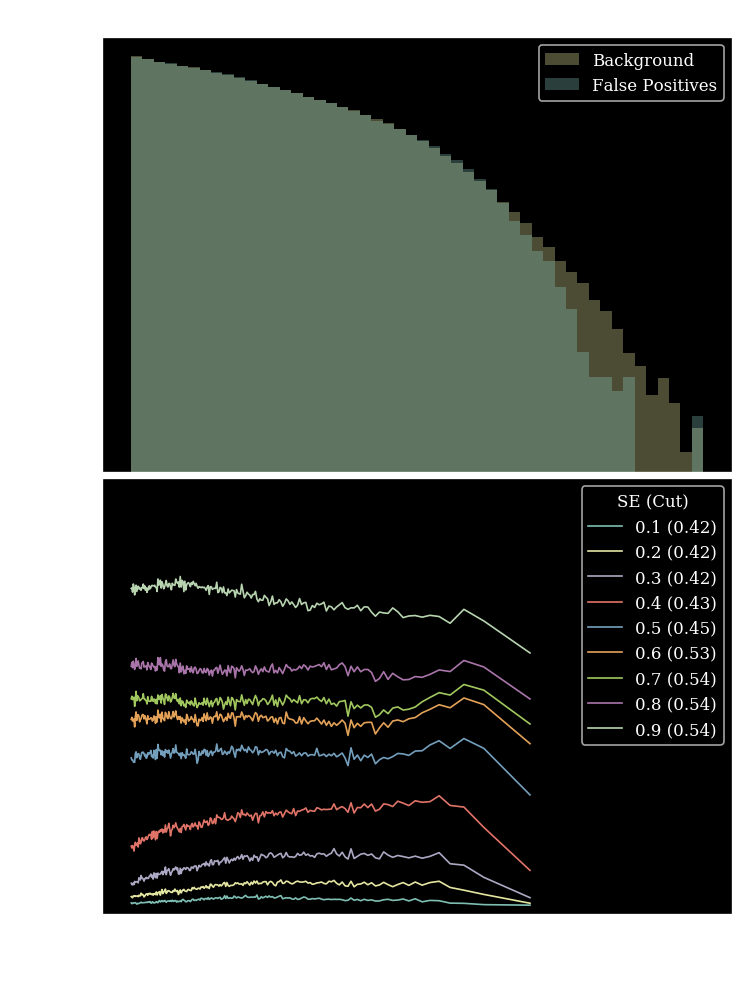

strength 300
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (834.6s)
 Train: loss:1.2906, acc:49% || Val: loss: 0.0962, acc:63%, R50: 2.5973, 1/JSD: 1376.2019


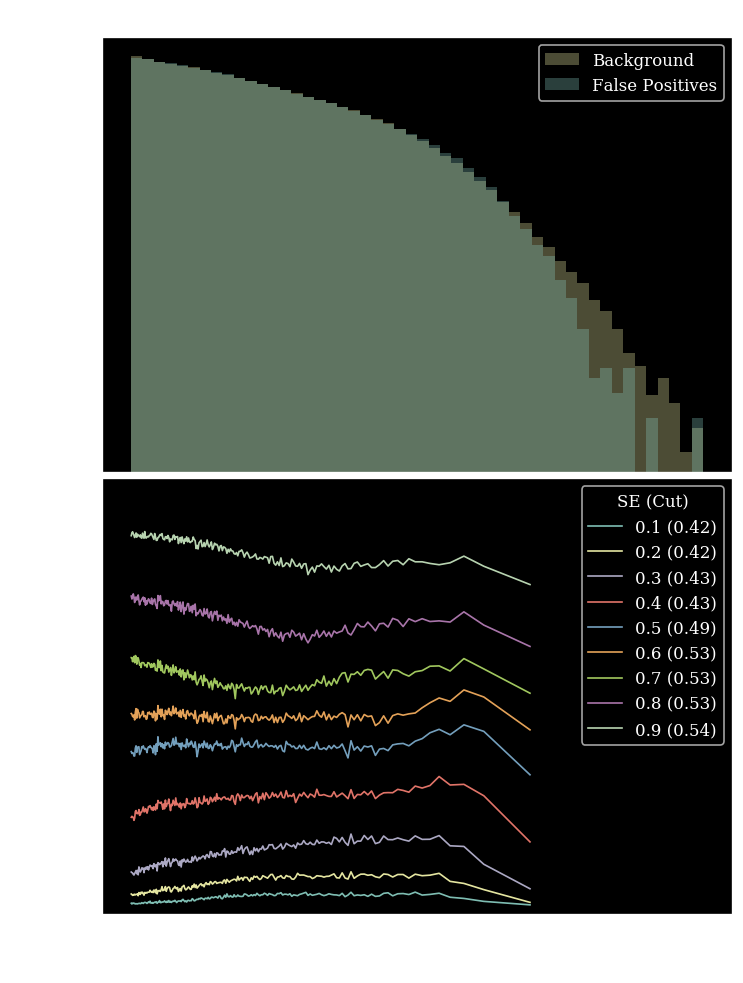

strength 1000
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (825.5s)
 Train: loss:2.9839, acc:49% || Val: loss: 0.0969, acc:60%, R50: 2.4711, 1/JSD: 1609.8776


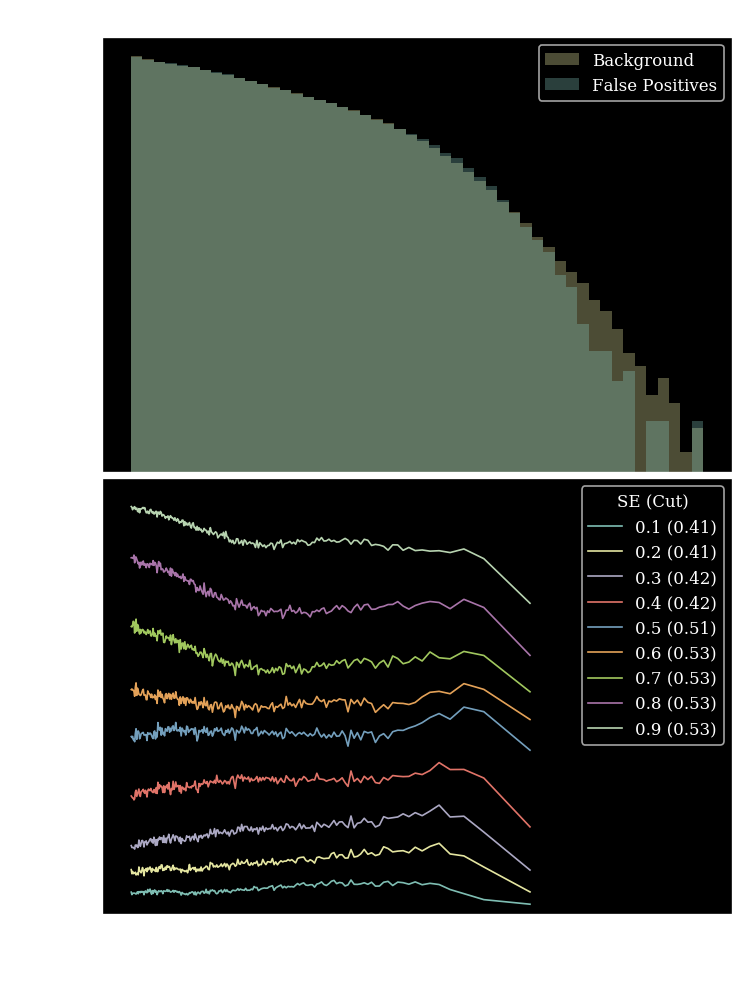

In [10]:
for i,frac in enumerate([200,300,1000]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    log=Logger("./logs/logWFCNDisLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"DisCo DNN str:{frac}",X=X,
                   y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
    jsdR50Disco.append(out)

Text(0, 0.5, '1/JSD')

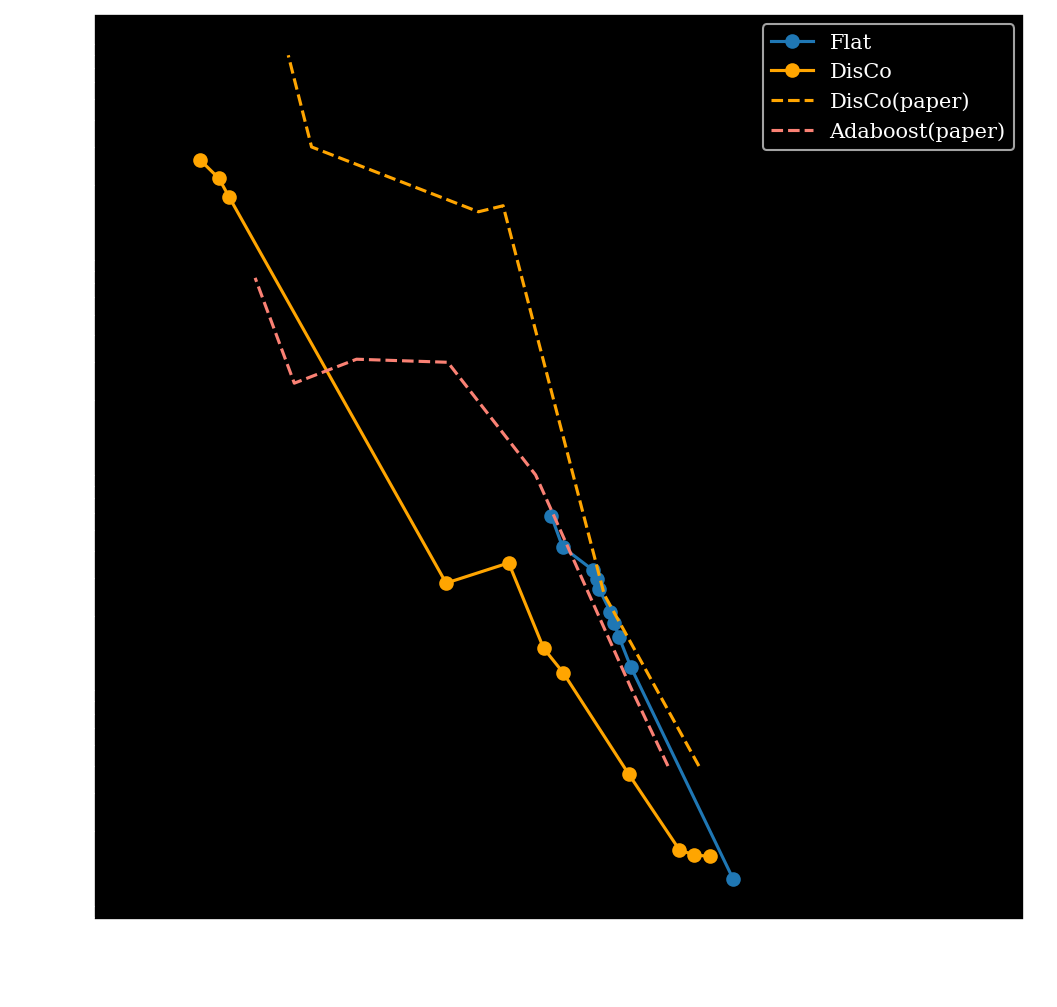

In [17]:
JSD,R50 = zip(*jsdR50flatstr[0::3][:-1])
JSD2,R502 = zip(*jsdR50Disco)
JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat',c='tab:blue')
plt.errorbar(R502,JSD2,fmt='-o',label='DisCo',c='orange')
plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right')
plt.xlabel('R50')
plt.ylabel('1/JSD')

# Flat with global memory 

In [ ]:
jsdR50flat = []
for i,bins in enumerate([1,2,5,10,50,60,75,85,100,110,120]):
    frac=50
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)
    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=1,bins=bins,memory=True)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN bins:{bins}",X=X,
                   y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
    jsdR50flat.append(out)

In [ ]:
jsdR50flatstrMem = []
for i,frac in enumerate([1,2,5,10,50,60,75,85,100,110,120]):
    for bins in [5,10,32]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=True)
        log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,
                       y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
        jsdR50flatstrMem.append(out)

In [ ]:
for i,frac in enumerate([150,175,200,228,256,500]):
    for bins in [5,10,32]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=True)
        log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,
                       y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
        jsdR50flatstrMem.append(out)

# No MSE loss test 

In [ ]:
jsdR50flatNA = []
for i,frac in enumerate([1,10,100]):
    for bins in [5,10,32,64,70,100]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,msefrac=0,memory=True)
        log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,
                       y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
        jsdR50flatNA.append(out)

In [ ]:
jsdR50flatstr

In [ ]:
jsdR50flatstrMem

In [ ]:
jsdR50Disco

In [ ]:
JSD,R50 = zip(*jsdR50flatstr[0::2])
JSD10,R5010 = zip(*jsdR50flatstrMem[0::3])
JSD11,R5011 = zip(*jsdR50flatstrMem[1::3])
JSD12,R5012 = zip(*jsdR50flatstrMem[2::3])
JSD2,R502 = zip(*jsdR50Disco)

JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat',c='tab:blue')
#plt.errorbar(R5010,JSD10,fmt='-o',label='Flat-Global',c='tab:purple')
plt.errorbar(R5011,JSD11,fmt='-o',label='Flat-Global',c='C4')
#plt.errorbar(R5012,JSD12,fmt='-o',label='Flat-Global',c='tab:red')
plt.errorbar(R502,JSD2,fmt='-o',label='DisCo',c='orange')
#plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
#plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right')
plt.xlabel('R50')
plt.ylabel('1/JSD')

In [ ]:
asdf adsf 

# Untrained model

In [ ]:
jsd_r50

In [ ]:
jsd_r50

In [ ]:
preds = np.array(model_L(X).tolist()).flatten()
#plt.hist(preds,bins=50,density=True,log=True)
plt.hist(preds[test_labels==0],bins=50,density=True,log=True,alpha=0.5)
plt.hist(preds[test_labels==1],bins=50,density=True,log=True,alpha=0.5)
plt.gcf().set_dpi(120)
plt.show()

# 2n point long time

In [ ]:
params['epochs'] = 1000
for i,bins in enumerate([20]):
    frac = 75
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,y=test_labels,x_biased=test[:,0])

In [ ]:
params['epochs'] = 300
params['interval'] = 20
model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,y=test_labels,x_biased=test[:,0])

In [ ]:
es = np.arange(0,11)*100
fig =plt.gcf()
fig, ax1 = plt.subplots(dpi=120,figsize=(10,8))

color = 'orange'
ax1.set_xlabel('epochs')
ax1.set_ylabel('R50', color=color)
ax1.errorbar(es, metrics_val_L.R50[:11], color=color,fmt="-o")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('1/JSD', color=color)  # we already handled the x-label with ax1
ax2.errorbar(es, 1/np.array(metrics_val_L.JSD[:11]), color=color,fmt="-o")
ax2.tick_params(axis='y', labelcolor=color,)

plt.show()

In [ ]:
#as a function of bins
jsd_r50 = list()
for i,bins in enumerate([10,20,30,50,80]):
    frac = 75
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,y=test_labels,x_biased=test[:,0])

    del model_L
    torch.cuda.empty_cache()
    jsd_r50.append(out)

In [ ]:
#as a function of bins
jsd_r50 = list()
for i,bins in enumerate([100,110,115,120,125,128,130,135,140,150]):
    frac = 75
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,y=test_labels,x_biased=test[:,0])

    del model_L
    torch.cuda.empty_cache()
    jsd_r50.append(out)

# As a function of bins

In [ ]:
#as a function of bins
jsd_r50 = list()
for i,bins in enumerate([128,130,135,140,150]):
    frac = 75
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)

In [ ]:
#as a function of str
jsd_r50 = list()
for i,frac in enumerate([15,50,60,75,100,150]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=128)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)

# As function of Frac 

In [ ]:
jsd_r50 = list()
for i,frac in enumerate([1,100,]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-2)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100,bins=32)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNnaiveLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)

In [ ]:
jsd_r50 = list()
for i,frac in enumerate([200,500,1e3]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNnaiveLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)

# DisCo

In [ ]:
for i,frac in enumerate([20,15,12,10,5,1,1e-1]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNDisLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    plot_stuff(model=model_L,name=f"DisCo DNN str{frac}",X=X,y=test_labels,x_biased=test[:,0])

# order 1 linear

In [ ]:
jsd_r50 = list()
for i,frac in enumerate([120,100,75,50,10,5,1,1e-1,1e-2]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100,order=1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNnaiveLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)